In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('monthly.csv',index_col=0)

df

,Price
Date,
1833-01,18.93
1833-02,18.93
1833-03,18.93
1833-04,18.93
1833-05,18.93
...,...
2025-03,2983.25
2025-04,3217.64
2025-05,3309.49


<Axes: xlabel='Date'>

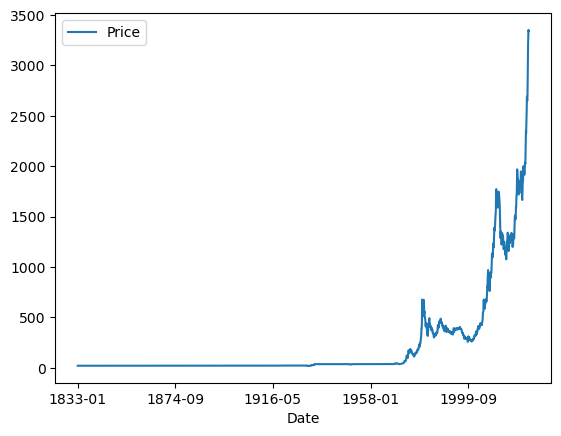

In [4]:
df.plot()

<Axes: xlabel='t-12'>

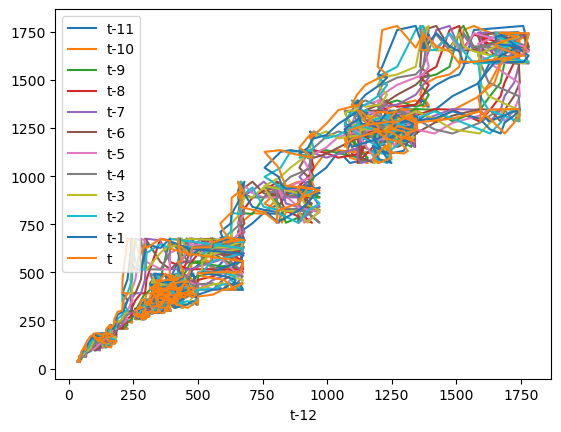

In [6]:
df = pd.read_csv('lags_12months_features.csv',index_col=0)
df.plot()


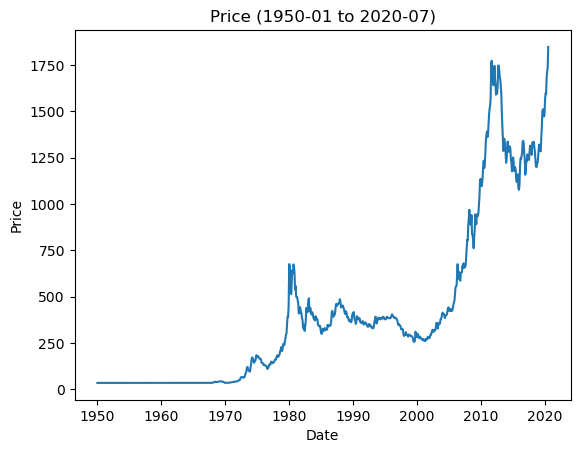

保存しました：/mnt/data/monthly_1950-01_2020-07.csv


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- 読み込み（アップロードファイル）----
df = pd.read_csv("monthly.csv")

# ---- 日付変換 ----
df["Date"] = pd.to_datetime(df["Date"])

# ---- 期間指定：1950-01 ～ 2020-07 ----
start = pd.Timestamp("1950-01-01")
end   = pd.Timestamp("2020-07-01")
df_period = df[(df["Date"] >= start) & (df["Date"] <= end)].copy()

# ---- プロット ----
plt.plot(df_period["Date"], df_period["Price"])
plt.title("Price (1950-01 to 2020-07)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# ---- CSV 保存 ----
df_period.to_csv("/mnt/data/monthly_1950-01_2020-07.csv", index=False, encoding="utf-8-sig")
print("保存しました：/mnt/data/monthly_1950-01_2020-07.csv")


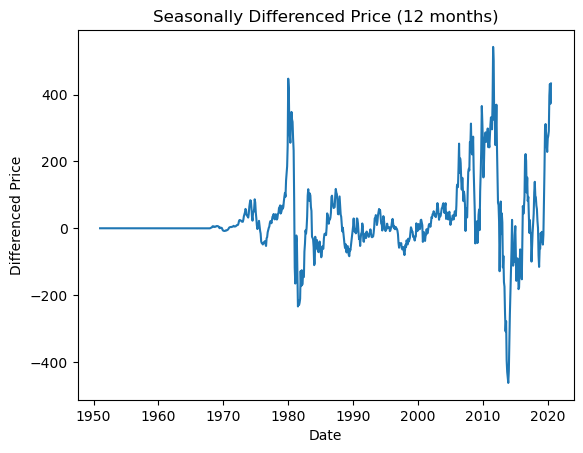

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# df_period がすでに期間フィルタ済みとする
# Date, Price の2列 → Price にだけ季節差分

# ---- seasonal difference (12 months) ----
differenced = df_period.copy()
differenced["Price"] = df_period["Price"].diff(12)

# ---- 最初の12行は NaN なので削除 ----
differenced = differenced.iloc[12:].reset_index(drop=True)

# ---- 保存 ----
differenced.to_csv("seasonally_adjusted.csv", index=False, encoding="utf-8-sig")

# ---- プロット ----
plt.plot(differenced["Date"], differenced["Price"])
plt.title("Seasonally Differenced Price (12 months)")
plt.xlabel("Date")
plt.ylabel("Differenced Price")
plt.show()




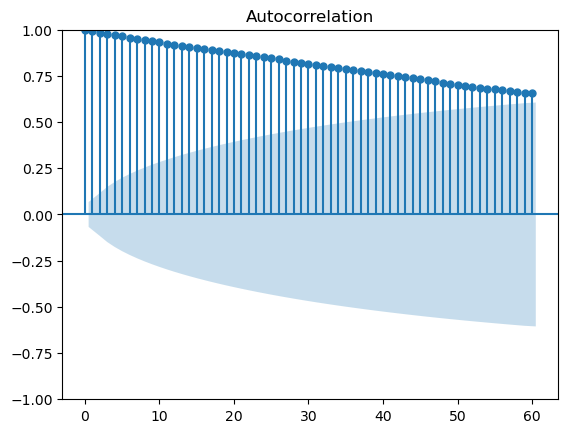

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(df_period["Price"].astype(float), lags=60)
plt.show()


In [24]:
import pandas as pd

# df_period を前提（Date と Price）
df2 = df_period.copy()

# Price を Series として取り出す
price = df2["Price"].astype(float)

# ---- supervised learning 用のラグ特徴量作成 ----
dataframe = pd.DataFrame()

# t-12, ..., t-1 を作成
for i in range(12, 0, -1):
    dataframe[f"t-{i}"] = price.shift(i)

# 現在値 t
dataframe["t"] = price.values

# 最初の12行は NaN なので削除
dataframe = dataframe.dropna().reset_index(drop=True)

print(dataframe.head())

# ---- 保存 ----
dataframe.to_csv("lags_12months_features_2.csv", index=False, encoding="utf-8-sig")
print("保存しました：lags_12months_features_2.csv")


    t-12   t-11   t-10    t-9    t-8    t-7    t-6    t-5    t-4    t-3  \
0  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72   
1  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72   
2  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72   
3  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72   
4  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72  34.72   

     t-2    t-1      t  
0  34.72  34.72  34.72  
1  34.72  34.72  34.72  
2  34.72  34.72  34.72  
3  34.72  34.72  34.72  
4  34.72  34.72  34.72  
保存しました：lags_12months_features_2.csv


In [25]:
# split into input and output
df = pd.read_csv('lags_12months_features_2.csv')
data = df.values
X = data[:,0:-1]
y = data[:,-1]

In [28]:
from sklearn.ensemble import RandomForestRegressor
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

[0.00120609 0.00203682 0.00162973 0.00564951 0.00641748 0.03560503
 0.02772743 0.0211189  0.02496123 0.055931   0.28353514 0.53418163]


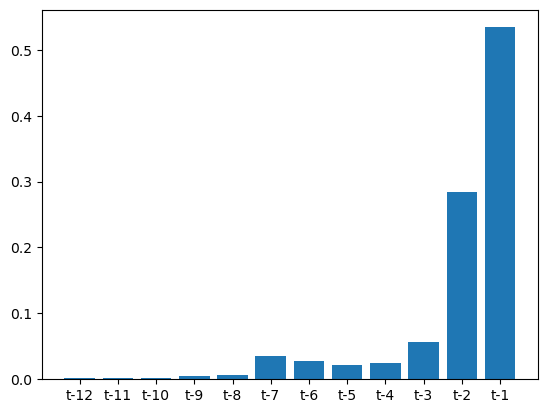

In [29]:
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names)
plt.show()

In [30]:
from sklearn.feature_selection import RFE
# perform feature selection
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=4)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = dataframe.columns.values[0:-1]
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])

Selected Features:
t-7
t-3
t-2
t-1


In [31]:
# report selected features
print('Selected Features:')
names = dataframe.columns.values[0:-1]
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])

Selected Features:
t-7
t-3
t-2
t-1


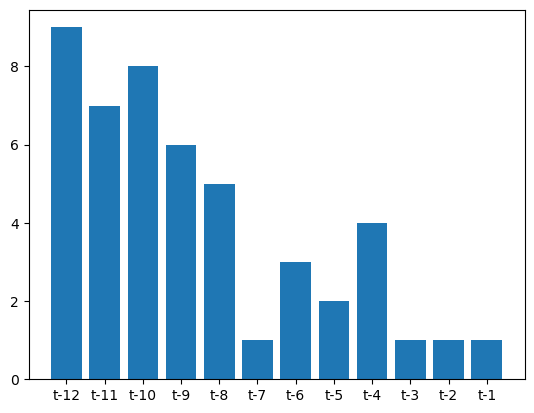

In [32]:
# plot feature rank
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names)
plt.show()

In [33]:
# AR example
from statsmodels.tsa.ar_model import AutoReg
from random import random
# fit model
model = AutoReg(y, lags=1)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  835
Model:                     AutoReg(1)   Log Likelihood               -3876.133
Method:               Conditional MLE   S.D. of innovations             25.247
Date:                Sat, 31 Jan 2026   AIC                           7758.266
Time:                        14:29:38   BIC                           7772.445
Sample:                             1   HQIC                          7763.702
                                  835                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5097      1.194      0.427      0.669      -1.830       2.849
y.L1           1.0040      0.002    518.899      0.000       1.000       1.008
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9961           +0.0000j            0.9961            0.0000
-----------------------------------------------------------------------------
"""

In [34]:
# AR example
from statsmodels.tsa.ar_model import AutoReg
from random import random
# fit model
model = AutoReg(y, lags=2)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  835
Model:                     AutoReg(2)   Log Likelihood               -3856.498
Method:               Conditional MLE   S.D. of innovations             24.797
Date:                Sat, 31 Jan 2026   AIC                           7720.996
Time:                        14:31:49   BIC                           7739.896
Sample:                             2   HQIC                          7728.242
                                  835                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6186      1.174      0.527      0.598      -1.682       2.919
y.L1           1.1968      0.034     34.806      0.000       1.129       1.264
y.L2          -0.1941      0.035     -5.618      0.000      -0.262      -0.126
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9966           +0.0000j            0.9966            0.0000
AR.2            5.1705           +0.0000j            5.1705            0.0000
-----------------------------------------------------------------------------
"""

In [35]:
# MA example
from statsmodels.tsa.arima.model import ARIMA
from random import random
# fit model
model = ARIMA(y, order=(0, 0, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(y), len(y))
print(yhat)
model_fit.summary()

[1232.76217156]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  835
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -5760.358
Date:                Sat, 31 Jan 2026   AIC                          11526.717
Time:                        14:42:19   BIC                          11540.899
Sample:                             0   HQIC                         11532.154
                                - 835                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        422.2001     29.191     14.464      0.000     364.988     479.413
ma.L1          0.9999      0.013     77.390      0.000       0.975       1.025
sigma2      5.706e+04   3835.241     14.878      0.000    4.95e+04    6.46e+04
===================================================================================
Ljung-Box (L1) (Q):                 557.71   Jarque-Bera (JB):               439.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.48   Skew:                             1.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
# ARMA example
from statsmodels.tsa.arima.model import ARIMA
from random import random
# fit model
model = ARIMA(y, order=(2, 0, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(y), len(y))
print(yhat)
model_fit.summary()

c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


[1865.43670479]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  835
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -3868.279
Date:                Sun, 01 Feb 2026   AIC                           7746.558
Time:                        10:46:07   BIC                           7770.195
Sample:                             0   HQIC                          7755.620
                                - 835                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        421.9247   3532.633      0.119      0.905   -6501.910    7345.759
ar.L1          0.5750      0.059      9.733      0.000       0.459       0.691
ar.L2          0.4243      0.059      7.193      0.000       0.309       0.540
ma.L1          0.6334      0.051     12.496      0.000       0.534       0.733
sigma2       613.2545     11.704     52.397      0.000     590.315     636.194
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):              6080.64
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):             204.38   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
# ARMA example
from statsmodels.tsa.arima.model import ARIMA
from random import random
# fit model
model = ARIMA(y, order=(2, 1, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(y), len(y))
print(yhat)
model_fit.summary()

[1866.99442359]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  835
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3857.508
Date:                Sun, 01 Feb 2026   AIC                           7723.016
Time:                        10:46:31   BIC                           7741.921
Sample:                             0   HQIC                          7730.264
                                - 835                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6169      0.053    -11.737      0.000      -0.720      -0.514
ar.L2          0.1043      0.025      4.138      0.000       0.055       0.154
ma.L1          0.8475      0.048     17.800      0.000       0.754       0.941
sigma2       609.4796     11.244     54.204      0.000     587.442     631.518
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6111.87
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):             194.26   Skew:                             1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# fit model
model = SARIMAX(y, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(y), len(y))
print(yhat)
model_fit.summary()

[1865.97887556]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  835
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3860.055
Date:                Sun, 01 Feb 2026   AIC                           7726.110
Time:                        10:46:51   BIC                           7740.288
Sample:                             0   HQIC                          7731.546
                                - 835                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4258      0.059     -7.237      0.000      -0.541      -0.310
ma.L1          0.6343      0.051     12.529      0.000       0.535       0.733
sigma2       613.2260     11.318     54.180      0.000     591.043     635.409
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              6050.27
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             187.36   Skew:                             1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(data)
model_fit = model.fit()

# 直近 k_ar ラグ分を渡す（k_ar=推定されたラグ次数）
lag_order = model_fit.k_ar
y_last = model_fit.endog[-lag_order:]     # shape: (k_ar, n_vars)

yhat = model_fit.forecast(y_last, steps=1)
print(yhat)

print(model_fit.summary())


[[1500.41      1510.58      1494.81      1470.79      1479.13
  1560.67      1597.1       1591.93      1683.17      1715.91
  1732.22      1846.51      1877.2296496]]
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 01, Feb, 2026
Time:                     10:48:59
--------------------------------------------------------------------
No. of Equations:         13.0000    BIC:                   -705.315
Nobs:                     834.000    HQIC:                  -705.951
Log likelihood:           279344.    FPE:               1.72851e-307
AIC:                     -706.346    Det(Omega_mle):    1.39215e-307
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error                t-stat            prob
------------------------------------------------------------------------------
const          0.000000         0.000000                22.144

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

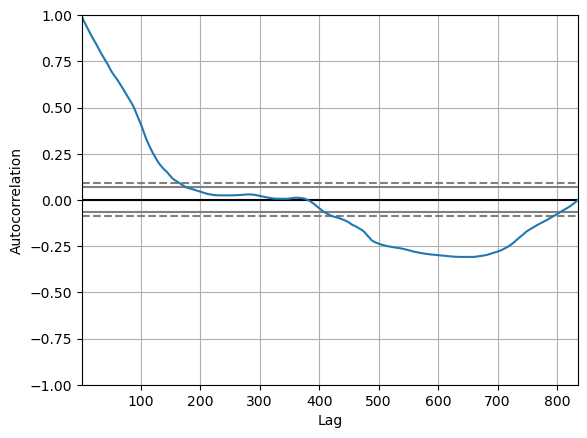

In [42]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)

In [43]:
data = pd.read_csv('lags_12months_features.csv')
data.columns

Index(['t-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3',
       't-2', 't-1', 't'],
      dtype='str')

In [45]:
import shap
X = data[['t-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3',
       't-2', 't-1']]
y = data['t']
from sklearn.linear_model import LinearRegression
new_model = LinearRegression()
new_model.fit(X,y)

c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [46]:
new_model.coef_

array([-0.15100351,  0.19632379, -0.06817981,  0.08718763, -0.10925495,
        0.09252929, -0.21378314,  0.22137822, -0.13142117,  0.19890588,
       -0.35356328,  1.22961449])

In [47]:
new_model.intercept_

np.float64(1.3946839179331505)

In [48]:
import lime
import lime.lime_tabular

ModuleNotFoundError: No module named 'lime'

In [49]:
import sys, site
print("exe:", sys.executable)
print("site:", site.getsitepackages()[:2])

exe: c:\Users\flare\miniforge3\envs\pymc_env\python.exe
site: ['c:\\Users\\flare\\miniforge3\\envs\\pymc_env', 'c:\\Users\\flare\\miniforge3\\envs\\pymc_env\\Lib\\site-packages']


In [50]:
import subprocess, sys
subprocess.run([sys.executable, "-m", "pip", "show", "lime"], capture_output=True, text=True).stdout


'Name: lime\nVersion: 0.2.0.1\nSummary: Local Interpretable Model-Agnostic Explanations for machine learning classifiers\nHome-page: http://github.com/marcotcr/lime\nAuthor: Marco Tulio Ribeiro\nAuthor-email: marcotcr@gmail.com\nLicense: BSD\nLocation: c:\\Users\\flare\\miniforge3\\envs\\pymc_env\\Lib\\site-packages\nRequires: matplotlib, numpy, scikit-image, scikit-learn, scipy, tqdm\nRequired-by: \n'

In [51]:
import os, sys, glob
print("cwd:", os.getcwd())
print("sys.path[0]:", sys.path[0])

hits = []
hits += glob.glob("lime.py")
hits += glob.glob("lime/*.py")
hits += glob.glob("lime")
print("local lime hits:", hits)


cwd: d:\musashino-university\xai
sys.path[0]: c:\Users\flare\miniforge3\envs\pymc_env\python311.zip
local lime hits: []


In [52]:
import sys, os, site, importlib.util, importlib

print("exe:", sys.executable)
print("has site-packages in sys.path?:", any("site-packages" in p for p in sys.path))

spec = importlib.util.find_spec("lime")
print("find_spec(lime):", spec)

# sys.path 上に lime の実体があるか総当たりで探す
cands = []
for p in sys.path:
    if not p or not isinstance(p, str):
        continue
    cands.append((p, os.path.exists(os.path.join(p, "lime.py")),
                    os.path.exists(os.path.join(p, "lime", "__init__.py"))))
hit = [x for x in cands if x[1] or x[2]]
print("hits:", hit[:20])
print("n_hits:", len(hit))


exe: c:\Users\flare\miniforge3\envs\pymc_env\python.exe
has site-packages in sys.path?: True
find_spec(lime): ModuleSpec(name='lime', loader=<_frozen_importlib_external.SourceFileLoader object at 0x0000022953B29CD0>, origin='c:\\Users\\flare\\miniforge3\\envs\\pymc_env\\Lib\\site-packages\\lime\\__init__.py', submodule_search_locations=['c:\\Users\\flare\\miniforge3\\envs\\pymc_env\\Lib\\site-packages\\lime'])
hits: [('c:\\Users\\flare\\miniforge3\\envs\\pymc_env\\Lib\\site-packages', False, True)]
n_hits: 1


In [53]:
import importlib, traceback

try:
    import lime
    print("lime imported:", lime.__file__)
except Exception:
    traceback.print_exc()


lime imported: c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\lime\__init__.py


In [54]:
import lime.lime_tabular
print("lime_tabular OK")


lime_tabular OK


In [55]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X),
                                                   mode='regression',
                                                  feature_names=X.columns,
                                                  class_names=['t'],
                                                  verbose=True)

In [56]:
explainer.feature_frequencies

{0: array([0.25, 0.25, 0.25, 0.25]),
 1: array([0.25, 0.25, 0.25, 0.25]),
 2: array([0.26108374, 0.23891626, 0.25      , 0.25      ]),
 3: array([0.25985222, 0.24014778, 0.25      , 0.25      ]),
 4: array([0.25862069, 0.24137931, 0.25      , 0.25      ]),
 5: array([0.25738916, 0.24261084, 0.25      , 0.25      ]),
 6: array([0.25615764, 0.24384236, 0.25      , 0.25      ]),
 7: array([0.25492611, 0.24507389, 0.25      , 0.25      ]),
 8: array([0.25369458, 0.24630542, 0.25      , 0.25      ]),
 9: array([0.25246305, 0.24753695, 0.25      , 0.25      ]),
 10: array([0.25123153, 0.24876847, 0.25      , 0.25      ]),
 11: array([0.25, 0.25, 0.25, 0.25])}

In [57]:
# asking for explanation for LIME model
i = 60
exp = explainer.explain_instance(np.array(X)[i],
                                 new_model.predict, 
                                 num_features=12
                                )

Intercept 535.4989970905644
Prediction_local [80.7220718]
Right: 36.34191083069711


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


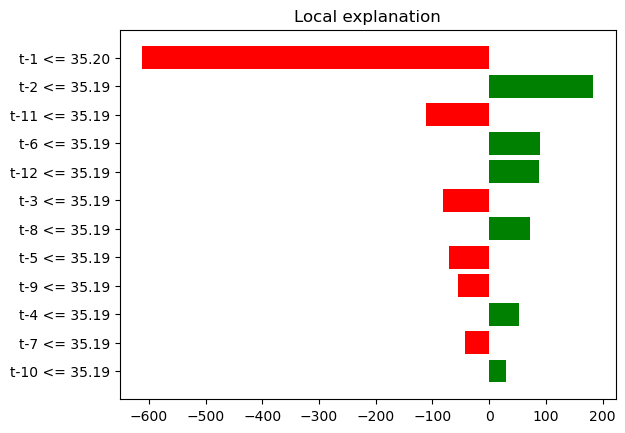

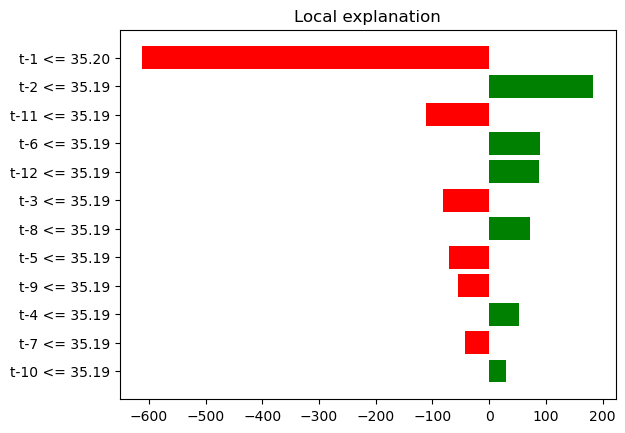

In [59]:
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()


In [60]:
exp.as_list()

[('t-1 <= 35.20', -611.5420992271365),
 ('t-2 <= 35.19', 183.70387983871098),
 ('t-11 <= 35.19', -110.62081486283599),
 ('t-6 <= 35.19', 90.3852887368179),
 ('t-12 <= 35.19', 87.3021265339981),
 ('t-3 <= 35.19', -81.15716537297092),
 ('t-8 <= 35.19', 71.64103116934305),
 ('t-5 <= 35.19', -70.12982561683512),
 ('t-9 <= 35.19', -55.08401714959025),
 ('t-4 <= 35.19', 52.68887735077599),
 ('t-7 <= 35.19', -41.82488372468009),
 ('t-10 <= 35.19', 29.86067702938458)]

In [61]:
# Code for SP-LIME
import warnings
from lime import submodular_pick

# Remember to convert the dataframe to matrix values
# SP-LIME returns exaplanations on a sample set to provide a non redundant global decision boundary of original model
sp_obj = submodular_pick.SubmodularPick(explainer, np.array(X), 
                                        new_model.predict, 
                                        num_features=12,
                                        num_exps_desired=10)

c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\lime\submodular_pick.py:57: UserWarning: Requested sample size larger than
                              size of input data. Using all data
  warnings.warn("""Requested sample size larger than
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 510.92859736784817
Prediction_local [126.30406935]
Right: 36.4599398680739
Intercept 386.32220309819223
Prediction_local [423.89668828]
Right: 325.27910225797115


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 516.9713516707928
Prediction_local [49.70533235]
Right: 36.45304101221403
Intercept 195.21810337741417
Prediction_local [1043.59924725]
Right: 609.0504691778137
Intercept 177.28528125193492
Prediction_local [1078.165491]
Right: 1228.2300570798818


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 193.44740717032346
Prediction_local [1029.12198788]
Right: 1755.7729798915084
Intercept 550.5142984383582
Prediction_local [-29.98333366]
Right: 36.320116321018084
Intercept 499.2888399266878
Prediction_local [76.41209255]
Right: 36.540035691694946
Intercept 192.6001498315929
Prediction_local [1043.9342976]
Right: 491.38888878585635


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegressi

Intercept 186.9592792240653
Prediction_local [1042.71251182]
Right: 1815.7465609206608
Intercept 544.8344409484375
Prediction_local [-9.12003029]
Right: 36.450389747717885
Intercept 431.4924704539278
Prediction_local [369.09586507]
Right: 377.00051433311745
Intercept 517.4723928174261
Prediction_local [75.52287337]
Right: 36.42536827999795


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 441.2411333624325
Prediction_local [280.16187326]
Right: 40.457168622606964
Intercept 435.601138259677
Prediction_local [319.34606541]
Right: 383.6713849419688
Intercept 197.93399324238632
Prediction_local [1052.40581729]
Right: 661.3059621483455


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 423.2267465225335
Prediction_local [291.92597318]
Right: 380.1097475226596
Intercept 536.8276554412887
Prediction_local [42.19838513]
Right: 36.42148059172696
Intercept 505.01513950801126
Prediction_local [101.42924692]
Right: 413.30058186183095
Intercept 430.54065176741625
Prediction_local [385.24697048]
Right: 385.49587257368233


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 456.97038628800476
Prediction_local [254.59528817]
Right: 297.6760840986951
Intercept 197.73209911560014
Prediction_local [1034.63396958]
Right: 907.4171408907528
Intercept 433.3838846957075
Prediction_local [346.64680898]
Right: 418.2599215464198
Intercept 174.49121181476391
Prediction_local [1089.37101139]
Right: 1153.3980337460441


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 550.9802672890058
Prediction_local [2.37419567]
Right: 36.50765981955939
Intercept 347.9983759008933
Prediction_local [555.55628519]
Right: 418.6470226881326
Intercept 193.42848319451429
Prediction_local [1063.32190719]
Right: 1586.7613876475502
Intercept 449.3437051480731
Prediction_local [302.64314512]
Right: 364.77407655177717


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 420.5662963010967
Prediction_local [351.63960843]
Right: 358.34189518492445
Intercept 491.0732704226348
Prediction_local [137.00164725]
Right: 154.27846742472917
Intercept 545.688043088389
Prediction_local [9.52436419]
Right: 36.46856114177397


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 464.12691671678766
Prediction_local [243.65774966]
Right: 40.94855208876247
Intercept 504.6809834590447
Prediction_local [154.36169789]
Right: 37.12149588332219
Intercept 158.3296922488767
Prediction_local [1125.75764205]
Right: 519.4583486164581
Intercept 515.8822836037693
Prediction_local [39.11039261]
Right: 36.05267042642171


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 205.14461916032738
Prediction_local [1007.93254653]
Right: 660.8133794856524
Intercept 495.7526713923402
Prediction_local [150.75042745]
Right: 37.245743636278206
Intercept 498.71812441017227
Prediction_local [114.50623274]
Right: 145.547272946005
Intercept 208.7436384874464
Prediction_local [1016.56338917]
Right: 1303.3459846381375
Intercept 509.39358735906757
Prediction_local [103.92751513]
Right: 277.37062709327637


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 529.5394728697398
Prediction_local [-7.31616656]
Right: 36.46661058656839
Intercept 490.2138355998331
Prediction_local [147.60748312]
Right: 293.7834473602079
Intercept 430.7758773516571
Prediction_local [322.90884116]
Right: 375.31823039379054


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 514.852612896862
Prediction_local [50.04188753]
Right: 36.33743459387419
Intercept 506.1418582281657
Prediction_local [48.85384493]
Right: 36.51008290121459
Intercept 196.39164530872705
Prediction_local [1020.67162616]
Right: 1237.1694678760216


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 573.3312505700037
Prediction_local [-33.76147932]
Right: 36.483484218202875


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 195.42827947762356
Prediction_local [1044.60114]
Right: 1308.840744030407


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 503.1137139144624
Prediction_local [119.52693031]
Right: 64.08424047037192
Intercept 422.5045466597661
Prediction_local [382.56363989]
Right: 386.66069891208207
Intercept 182.3883905429182
Prediction_local [1069.68300099]
Right: 1771.4222762370778


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 527.3401182897468
Prediction_local [19.95681809]
Right: 36.42227652184455
Intercept 142.36356252444557
Prediction_local [1200.91315136]
Right: 475.2715758546263
Intercept 185.86242669159697
Prediction_local [1084.54186132]
Right: 1364.9074682648063
Intercept 459.8727881212818
Prediction_local [199.86065328]
Right: 37.420370163716406


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 384.6513473162113
Prediction_local [444.48484236]
Right: 356.61133963908867
Intercept 484.9309328444932
Prediction_local [193.69454523]
Right: 291.83978121399446
Intercept 198.76610977863368
Prediction_local [1038.14628056]
Right: 1292.7297203969802
Intercept 430.15946860050644
Prediction_local [326.26177363]
Right: 395.7233686606016


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 507.60012311522405
Prediction_local [79.40685193]
Right: 36.45522359962045
Intercept 184.4705119958736
Prediction_local [1068.82170863]
Right: 1174.1444726348977
Intercept 464.1570356739292
Prediction_local [213.41866438]
Right: 36.555917271121174
Intercept 548.9048815720267
Prediction_local [-8.39307695]
Right: 36.43320240244623


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegressi

Intercept 413.6003729854003
Prediction_local [388.45942585]
Right: 384.4349855696986
Intercept 386.4953006985869
Prediction_local [428.83958879]
Right: 345.0136173544591
Intercept 222.18215439136895
Prediction_local [942.25812265]
Right: 443.3402303570958
Intercept 205.47139241898955
Prediction_local [978.57358433]
Right: 1123.9274931314367
Intercept 537.0436034983446
Prediction_local [67.91234957]
Right: 306.49488327657735
Intercept 498.4983585684158
Prediction_local [151.07139443]
Right: 320.21196113652127
Intercept 176.47492709459434
Prediction_local [1077.66016036]
Right: 452.3757677856882


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 531.109395417045
Prediction_local [0.40571111]
Right: 36.25978228669651
Intercept 507.69660961152965
Prediction_local [58.25500671]
Right: 36.44362169039337
Intercept 542.9130690433927
Prediction_local [53.18136069]
Right: 36.3489763214055
Intercept 524.3415364611859
Prediction_local [-7.77659613]
Right: 36.40564381747451


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 482.20816112512256
Prediction_local [177.03796313]
Right: 137.50008133934998
Intercept 487.39655116828305
Prediction_local [181.00493766]
Right: 115.06237844079394
Intercept 527.5162977229045
Prediction_local [18.03690466]
Right: 36.240924678870975


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 212.5823986982404
Prediction_local [968.95588685]
Right: 627.1742178597149
Intercept 440.5788480549281
Prediction_local [343.8736698]
Right: 388.69661840974226
Intercept 523.5418661904125
Prediction_local [49.84211623]
Right: 36.36018027442625


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 206.79192562290987
Prediction_local [1007.11470532]
Right: 869.3831093607312


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 559.0160130559987
Prediction_local [-74.62010899]
Right: 36.06856799890358
Intercept 392.420690506567
Prediction_local [398.54385694]
Right: 398.17896645687335


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 493.111449560955
Prediction_local [157.60806838]
Right: 166.0260765102195
Intercept 497.27334376613396
Prediction_local [201.89605883]
Right: 36.86299506882996
Intercept 513.3512046562643
Prediction_local [121.0705408]
Right: 291.455218542546


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 525.135324497837
Prediction_local [-1.54403681]
Right: 36.43892301582208
Intercept 464.09176340681086
Prediction_local [230.8647838]
Right: 271.74318559316123
Intercept 509.7757784091744
Prediction_local [146.71028631]
Right: 86.78965320826097


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 500.46546151131776
Prediction_local [64.83195488]
Right: 36.41766179244552
Intercept 512.7885480700288
Prediction_local [122.11365592]
Right: 45.19996426456042
Intercept 556.5662522960382
Prediction_local [-39.80815445]
Right: 36.49681801131197
Intercept 557.8927089759674
Prediction_local [-40.79689366]
Right: 35.992494480577264


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 495.0234040047403
Prediction_local [119.46358394]
Right: 36.460602092526635
Intercept 540.0374497316395
Prediction_local [12.09343269]
Right: 36.44926467378268
Intercept 189.99630242610937
Prediction_local [1020.38772641]
Right: 1218.4165186132982
Intercept 502.85284124928296
Prediction_local [147.9808672]
Right: 292.9348052625529
Intercept 369.05058448751987
Prediction_local [488.45893351]
Right: 405.0249230667085
Intercept 201.95375714566165
Prediction_local [1008.82984111]
Right: 1141.173921225631


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 219.80306517009717
Prediction_local [995.69741546]
Right: 1226.3796216705052
Intercept 560.3849993370341
Prediction_local [-40.60637712]
Right: 36.54060821859267
Intercept 528.1732239711868
Prediction_local [78.8688085]
Right: 36.52098434795849
Intercept 486.9528088327838
Prediction_local [138.45439298]
Right: 135.0108799693473


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 505.4479413332275
Prediction_local [84.8026018]
Right: 134.36522733803343
Intercept 426.25333060384725
Prediction_local [354.39358738]
Right: 413.99345006737224
Intercept 406.64362446514593
Prediction_local [404.24737946]
Right: 370.4694742015417
Intercept 93.34515185378768
Prediction_local [1340.43697669]
Right: 441.05522059125093


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegressi

Intercept 535.4492834195339
Prediction_local [44.67548196]
Right: 36.52890050649981
Intercept 427.3105540459984
Prediction_local [319.72380365]
Right: 327.8937179321812
Intercept 386.3380443143524
Prediction_local [428.81457702]
Right: 329.5012033994345
Intercept 478.1679415385773
Prediction_local [202.24983952]
Right: 287.706120401753


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 470.7913392948409
Prediction_local [215.166656]
Right: 286.25373459441255
Intercept 460.166506514483
Prediction_local [226.79812405]
Right: 192.06744271990246
Intercept 473.0755758784071
Prediction_local [174.36901847]
Right: 293.1482003398758


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 484.99577622467126
Prediction_local [118.22272376]
Right: 153.63596102423256
Intercept 220.0377790022071
Prediction_local [971.86328458]
Right: 470.9853457679367
Intercept 393.29395290400544
Prediction_local [463.13169302]
Right: 410.91146200276563


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 423.56188420360684
Prediction_local [389.47185426]
Right: 392.9461874691926
Intercept 478.0727918259147
Prediction_local [165.95098321]
Right: 300.6894568551343
Intercept 496.6220734029753
Prediction_local [123.56749201]
Right: 312.9501253853379
Intercept 410.6600450582288
Prediction_local [366.52198191]
Right: 400.9897548347378


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 500.20897570019156
Prediction_local [148.60297813]
Right: 293.3928561589007
Intercept 493.0839748694248
Prediction_local [182.78499847]
Right: 276.84249454293666
Intercept 526.7676365744042
Prediction_local [2.52911099]
Right: 36.48982609173603


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 216.05509640376562
Prediction_local [965.92241658]
Right: 676.2502319728278
Intercept 530.1869808184983
Prediction_local [92.6908135]
Right: 105.5261473100282
Intercept 420.6920075020366
Prediction_local [404.93527222]
Right: 384.11804352718707


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 174.42758047113682
Prediction_local [1109.70428839]
Right: 493.38061648742354
Intercept 484.6714868808899
Prediction_local [151.27074507]
Right: 180.86627227925933
Intercept 483.431118519626
Prediction_local [132.49720432]
Right: 38.62377216957661
Intercept 211.445920197503
Prediction_local [1007.6555392]
Right: 1326.854784193292


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 521.2599702744561
Prediction_local [33.91582752]
Right: 36.381950922084535
Intercept 183.16219233072425
Prediction_local [1053.64713099]
Right: 1616.7681163986047
Intercept 516.329933656059
Prediction_local [74.37220054]
Right: 36.48084528618952


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 422.0010717514059
Prediction_local [372.37207605]
Right: 349.9729146535076
Intercept 493.81918083727305
Prediction_local [174.91855242]
Right: 274.0658656838691
Intercept 525.6842145424154
Prediction_local [21.73264505]
Right: 36.083751473490416
Intercept 206.1265846898867
Prediction_local [1019.99578927]
Right: 1061.381581776289


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 201.94572758326777
Prediction_local [1034.48074327]
Right: 650.8587373338378
Intercept 502.11217274009385
Prediction_local [109.05846064]
Right: 432.7345673258307
Intercept 497.434627784033
Prediction_local [133.98488841]
Right: 42.11199279607416
Intercept 527.091572882657
Prediction_local [46.9041999]
Right: 36.487371494611594


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 468.43845239590325
Prediction_local [256.31503579]
Right: 376.1050733507231
Intercept 507.6438577211832
Prediction_local [61.74464717]
Right: 36.43811321686498
Intercept 428.9569824186406
Prediction_local [334.60105953]
Right: 337.9639017937376
Intercept 518.7767212645039
Prediction_local [65.49303354]
Right: 36.449452169748284


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 547.3800126954334
Prediction_local [0.35519783]
Right: 36.30580789511083
Intercept 196.94733130908548
Prediction_local [1014.29267228]
Right: 1700.4437670653422
Intercept 469.3793909787717
Prediction_local [173.68705264]
Right: 289.3688272779378


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 399.2514127504878
Prediction_local [392.2582206]
Right: 390.2828537108866
Intercept 540.5536746471879
Prediction_local [12.20587201]
Right: 35.977921061022016
Intercept 526.6696599288332
Prediction_local [36.95343197]
Right: 36.4384214831711
Intercept 373.03323272908113
Prediction_local [455.51282495]
Right: 338.17432889488447


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 444.69717595821146
Prediction_local [269.92845442]
Right: 339.9850297284982
Intercept 379.9842549015764
Prediction_local [422.29766029]
Right: 371.2343340103376
Intercept 456.7418002614023
Prediction_local [229.9090506]
Right: 39.395410363660545


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 209.04169814226802
Prediction_local [1004.30732996]
Right: 825.5975326679793
Intercept 473.7487550572374
Prediction_local [239.17610861]
Right: 243.04644540164742
Intercept 524.9172618938551
Prediction_local [85.71734932]
Right: 36.44622804761434


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 475.4449012281383
Prediction_local [136.86578092]
Right: 43.681830641500284
Intercept 199.76917818452404
Prediction_local [1017.79200688]
Right: 1356.2618361701834
Intercept 538.2028229613853
Prediction_local [51.18836618]
Right: 36.46360639922348


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 196.36231458371566
Prediction_local [1041.97225363]
Right: 1209.386311323691
Intercept 404.605055434994
Prediction_local [425.3676733]
Right: 322.8223009647711
Intercept 205.6896070005772
Prediction_local [994.92108002]
Right: 800.5791572695327
Intercept 392.2587987126126
Prediction_local [428.92519258]
Right: 384.18714654831774


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 185.80367457768637
Prediction_local [1071.16887324]
Right: 817.7395710412409


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 410.7540039646413
Prediction_local [321.20916599]
Right: 370.3269224526665
Intercept 464.15103877741694
Prediction_local [220.51148187]
Right: 414.9840229615746
Intercept 501.01210787604293
Prediction_local [176.61761756]
Right: 41.4763156802405
Intercept 433.8689384934333
Prediction_local [339.76904225]
Right: 330.1243578655249


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 513.7655473837343
Prediction_local [90.71679463]
Right: 36.56355139777932
Intercept 202.629249178154
Prediction_local [1009.24704669]
Right: 1255.6651574429538
Intercept 544.3105900691664
Prediction_local [0.27541777]
Right: 36.079266220193134


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 473.6448729462211
Prediction_local [190.70873406]
Right: 36.68162397900573
Intercept 531.4935868315629
Prediction_local [5.7377262]
Right: 36.520646092596934
Intercept 237.7673091604068
Prediction_local [917.61583976]
Right: 459.77692811706135


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 503.9740542251184
Prediction_local [69.15621336]
Right: 36.527429267958105
Intercept 415.98977880953515
Prediction_local [383.21052241]
Right: 379.22008489956994
Intercept 411.84242145930494
Prediction_local [412.58741047]
Right: 411.7480908227869


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 492.50317099142194
Prediction_local [220.54896555]
Right: 42.68285732050129
Intercept 425.1298225464656
Prediction_local [318.62809843]
Right: 399.4516520647956
Intercept 413.66520886795655
Prediction_local [395.44078039]
Right: 382.76632022294785


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 492.8366365899229
Prediction_local [197.14888983]
Right: 172.34940106917182
Intercept 209.05294255768507
Prediction_local [1014.17239034]
Right: 670.1690446209286
Intercept 188.07382510636495
Prediction_local [1050.98091727]
Right: 481.66603014855036


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 173.4927185803005
Prediction_local [1099.22908856]
Right: 1215.032949145236
Intercept 200.97396269976542
Prediction_local [1005.58139252]
Right: 1453.8176635339194
Intercept 209.78840868023602
Prediction_local [982.03940247]
Right: 453.5460465763612


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 191.30813588345836
Prediction_local [1061.7413117]
Right: 450.1238854983031
Intercept 186.68115462936325
Prediction_local [1054.36143861]
Right: 1221.544211210549
Intercept 196.55519226571607
Prediction_local [1013.37746086]
Right: 434.462020493646


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 527.0756348398559
Prediction_local [43.71233059]
Right: 36.32610166013384
Intercept 460.27895450556304
Prediction_local [216.61604999]
Right: 147.43238658826982
Intercept 414.77735258937486
Prediction_local [376.77257581]
Right: 336.301547571393


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 337.59375497515174
Prediction_local [561.4958249]
Right: 377.96315741449695
Intercept 180.27245396404652
Prediction_local [1079.70062249]
Right: 1236.751781589546
Intercept 405.71243435896173
Prediction_local [409.74241841]
Right: 384.9930202705247


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 520.5278450951961
Prediction_local [22.6649298]
Right: 36.25641343731212
Intercept 467.2774839707395
Prediction_local [170.04929376]
Right: 285.67862234507953
Intercept 189.51051087581965
Prediction_local [1052.63945094]
Right: 1744.5524927210547


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegressi

Intercept 190.12465807161175
Prediction_local [1053.61493196]
Right: 1300.0196169373176
Intercept 182.3828965547321
Prediction_local [1063.52740391]
Right: 915.9323912636244
Intercept 487.74906107784636
Prediction_local [165.5266641]
Right: 294.4192314409983
Intercept 507.79346136689134
Prediction_local [24.94742371]
Right: 36.25992053813319


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 198.20259943222874
Prediction_local [1050.36681912]
Right: 1260.7428458270692
Intercept 469.32202841798824
Prediction_local [223.16663278]
Right: 300.8887452448192
Intercept 461.27413710160465
Prediction_local [202.0313682]
Right: 133.30384504311542


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 393.67404670673653
Prediction_local [435.57566764]
Right: 352.88668813355724
Intercept 184.6971056280691
Prediction_local [1034.79253568]
Right: 1263.9835151060558
Intercept 180.17968754502817
Prediction_local [1076.24164664]
Right: 1296.8123887180861


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 513.7746616527987
Prediction_local [50.66445378]
Right: 36.4658050306792
Intercept 518.7038404253537
Prediction_local [78.14890352]
Right: 36.4335345947104
Intercept 395.8673890857305
Prediction_local [432.86628613]
Right: 319.2258247891819


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 398.63968538593423
Prediction_local [390.90688464]
Right: 387.61621055944653
Intercept 199.80917936568403
Prediction_local [1045.97019474]
Right: 1664.0324027865129
Intercept 546.4743238831147
Prediction_local [-21.30525893]
Right: 36.17876615629553


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 415.45740390268344
Prediction_local [361.50554921]
Right: 390.87556005619894
Intercept 505.85722796850916
Prediction_local [130.43429633]
Right: 281.6658408544684
Intercept 509.24293895477183
Prediction_local [85.77803902]
Right: 36.432436551209776


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 499.86749425927275
Prediction_local [152.69790741]
Right: 284.89773255020754
Intercept 503.87265431736284
Prediction_local [135.64958828]
Right: 142.94167219942682
Intercept 181.16628354717358
Prediction_local [1073.2154366]
Right: 1321.6166126416208


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 470.20806697590797
Prediction_local [183.35825935]
Right: 304.3194256327367


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 513.9000517202982
Prediction_local [38.4429934]
Right: 36.53673516440311
Intercept 491.8174596359763
Prediction_local [155.63068859]
Right: 257.7835263900935
Intercept 403.3938051522189
Prediction_local [397.76492078]
Right: 351.7542447916364


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 492.47001896294023
Prediction_local [165.25120727]
Right: 166.3573957371301
Intercept 382.39640639476767
Prediction_local [427.23317491]
Right: 393.8662389639172
Intercept 195.55362095278417
Prediction_local [1018.91415964]
Right: 1576.2725339022375
Intercept 470.65932977420994
Prediction_local [206.95313696]
Right: 39.844457869854736


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 513.9040159530178
Prediction_local [63.00760025]
Right: 295.75125493357007
Intercept 493.71152652067167
Prediction_local [135.16483583]
Right: 36.449153795915734
Intercept 195.52740989015783
Prediction_local [1030.25326224]
Right: 615.9870334023988


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 454.05953014722445
Prediction_local [240.22884562]
Right: 258.9066450388455
Intercept 211.67977373732992
Prediction_local [986.13743733]
Right: 544.9374314610718
Intercept 527.6057398835271
Prediction_local [57.735892]
Right: 36.47984105553137


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegressi

Intercept 435.4797245111872
Prediction_local [332.66617509]
Right: 350.3253425495849
Intercept 180.31883641851982
Prediction_local [1067.17986009]
Right: 615.9400097399946
Intercept 463.0353289169718
Prediction_local [225.07479718]
Right: 287.89905487450875


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 440.55069899229426
Prediction_local [345.55995878]
Right: 340.2505676871053
Intercept 366.4551528757222
Prediction_local [493.09394004]
Right: 355.75692359806516
Intercept 447.07417155744525
Prediction_local [246.37867102]
Right: 36.82158923622182


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 526.5022761583404
Prediction_local [72.64322559]
Right: 36.07193637511559
Intercept 488.69856646172946
Prediction_local [185.54430911]
Right: 169.23419429802334
Intercept 519.3641776622505
Prediction_local [49.89694481]
Right: 36.43816887900148


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 538.9922046285436
Prediction_local [-7.78148986]
Right: 36.43322880429283
Intercept 391.4744464403118
Prediction_local [389.79471057]
Right: 399.882930075028
Intercept 488.84526439317165
Prediction_local [138.47887206]
Right: 188.3328015116031


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 493.53086585938206
Prediction_local [138.16870823]
Right: 50.01697605156515
Intercept 434.1259052736362
Prediction_local [368.46064048]
Right: 384.60810694528885
Intercept 199.6168282299644
Prediction_local [1012.98652128]
Right: 1359.3805942061986


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 193.69250252978804
Prediction_local [1044.17336681]
Right: 1255.845710070068
Intercept 206.48182323410626
Prediction_local [1011.61763205]
Right: 1282.6472522461615
Intercept 466.94727819554663
Prediction_local [203.14466474]
Right: 57.20414592276282


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 568.640090558428
Prediction_local [-55.54211255]
Right: 36.44703643752109
Intercept 474.7511137848704
Prediction_local [187.94857031]
Right: 179.53239814492184
Intercept 430.40577176755977
Prediction_local [340.50688607]
Right: 368.0182681527839
Intercept 528.7741136209751
Prediction_local [69.52220006]
Right: 36.468368217307265


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 486.7967061498283
Prediction_local [174.30245886]
Right: 144.49545667188187
Intercept 553.2772251140196
Prediction_local [-3.91237581]
Right: 36.44263473908329


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 392.2230051109351
Prediction_local [409.79259441]
Right: 322.31133531630473
Intercept 521.8333520034754
Prediction_local [100.54267038]
Right: 36.325964258714464


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 193.26874775448528
Prediction_local [1047.72689209]
Right: 847.0892825433689
Intercept 480.5037129232784
Prediction_local [229.14266547]
Right: 263.4952532225698


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 527.1155296159253
Prediction_local [26.13196355]
Right: 36.46259218738637
Intercept 403.15844787050077
Prediction_local [396.16730912]
Right: 406.0001900149541
Intercept 391.3942862572427
Prediction_local [428.46988247]
Right: 362.3182306898115


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 199.87396210111683
Prediction_local [1025.3182968]
Right: 1392.9699233683937
Intercept 483.5172209322555
Prediction_local [145.70999954]
Right: 43.19996411525554
Intercept 463.61862261320925
Prediction_local [205.49946074]
Right: 281.1183549242338


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 481.77661584441745
Prediction_local [223.11895627]
Right: 36.770927924135364
Intercept 185.25250049245804
Prediction_local [1071.37209737]
Right: 1490.2217554072768


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 407.1848858517493
Prediction_local [423.49599134]
Right: 329.42192002368876
Intercept 502.85953706977546
Prediction_local [129.67460592]
Right: 268.8927230632959
Intercept 507.3939674834842
Prediction_local [83.56222698]
Right: 41.16374829294096


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 210.1294236578712
Prediction_local [1010.63634988]
Right: 575.3961446533654
Intercept 188.02414959281458
Prediction_local [1052.0643274]
Right: 500.0261380316703


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 441.15830970990663
Prediction_local [309.38407956]
Right: 377.5606485151454
Intercept 197.77232210820864
Prediction_local [1050.56018122]
Right: 992.216207165857
Intercept 427.2503080678979
Prediction_local [330.80442902]
Right: 306.7369720155314


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 432.7625993544288
Prediction_local [356.10388278]
Right: 353.0891080608175
Intercept 400.57953038267976
Prediction_local [419.25688604]
Right: 344.2722293349427
Intercept 401.898040069218
Prediction_local [401.45345153]
Right: 327.86445872986127


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 381.70170827052476
Prediction_local [434.16410464]
Right: 379.2731760710645


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 551.0146347610903
Prediction_local [-19.16916095]
Right: 36.23171270404251
Intercept 506.83226498729215
Prediction_local [83.13527242]
Right: 36.34770380449835


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 183.4087548699854
Prediction_local [1077.59511933]
Right: 1326.0765285025325
Intercept 503.42074800032316
Prediction_local [86.58146291]
Right: 38.486795680082395
Intercept 477.5405843618629
Prediction_local [161.74075087]
Right: 109.50067324570087


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 541.2008818432755
Prediction_local [19.90366623]
Right: 36.398211817076984
Intercept 506.0542138166393
Prediction_local [71.17523967]
Right: 36.44254974218337
Intercept 179.15922562544645
Prediction_local [1078.0601587]
Right: 1274.5964785333406


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 532.222126371694
Prediction_local [58.71072947]
Right: 36.45614375946653


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 391.86089959070125
Prediction_local [495.18531209]
Right: 373.25215460738644
Intercept 452.701502062327
Prediction_local [240.00012491]
Right: 36.551964993082876
Intercept 545.7980307318006
Prediction_local [-10.69096252]
Right: 36.242751913846185


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 410.7095212664476
Prediction_local [370.52423126]
Right: 341.44257782230505
Intercept 515.8698867596356
Prediction_local [79.00514276]
Right: 36.278397888159205
Intercept 199.6205215207872
Prediction_local [1035.17720507]
Right: 927.6050228217384


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 457.8731138852248
Prediction_local [178.3025332]
Right: 105.8045958930144
Intercept 419.8208148653614
Prediction_local [353.59917443]
Right: 361.27633867930916
Intercept 424.5802345026528
Prediction_local [389.82973555]
Right: 316.95712041547114


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 525.0236959423916
Prediction_local [57.01390748]
Right: 36.43025359727712
Intercept 516.9075677223304
Prediction_local [59.57727084]
Right: 36.06927171857236
Intercept 512.8560990866839
Prediction_local [41.76908947]
Right: 36.454913665461596
Intercept 463.41378150292627
Prediction_local [189.84857644]
Right: 284.01281514761473


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 501.399332410747
Prediction_local [90.3332675]
Right: 36.54518408444163
Intercept 418.65971816303215
Prediction_local [350.87185979]
Right: 382.00683993501315
Intercept 212.06406239926253
Prediction_local [964.01239101]
Right: 971.1343253627492
Intercept 477.7945150067545
Prediction_local [190.06482135]
Right: 287.2615300554807


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 183.01640146214652
Prediction_local [1084.41058606]
Right: 1073.5614556110636
Intercept 520.8421941035003
Prediction_local [75.99369173]
Right: 36.37247089704276
Intercept 208.24782249706575
Prediction_local [986.14791205]
Right: 1294.0421033804885
Intercept 411.7709910778475
Prediction_local [378.97768965]
Right: 394.4725371468067
Intercept 489.4425326601139
Prediction_local [102.17075354]
Right: 127.40922088673194
Intercept 462.4641531038864
Prediction_local [204.12626595]
Right: 263.699751133514


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 419.8757913191224
Prediction_local [375.1367685]
Right: 342.05323461712544
Intercept 525.988240751123
Prediction_local [30.92307378]
Right: 36.40496163774837
Intercept 485.3790461721794
Prediction_local [147.57345234]
Right: 36.9342383722275


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 534.2830695802695
Prediction_local [70.92903196]
Right: 36.435943556942476


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 484.73854624323354
Prediction_local [167.25241874]
Right: 184.41705155672673
Intercept 423.40372486424667
Prediction_local [335.38660866]
Right: 375.38381731310704
Intercept 399.87437549132784
Prediction_local [445.34601548]
Right: 385.7730429490977


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 439.8336054730409
Prediction_local [336.01640735]
Right: 384.746354965015
Intercept 538.9231012928487
Prediction_local [1.9191094]
Right: 36.42723352713086
Intercept 502.49635625438094
Prediction_local [101.76490897]
Right: 36.475252229787685


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 417.5342977143292
Prediction_local [386.06782716]
Right: 334.9872112318782
Intercept 199.65925767475812
Prediction_local [1035.08330945]
Right: 802.9289844610803
Intercept 400.0563109661508
Prediction_local [352.48002433]
Right: 424.52462996332156


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 522.8527913669321
Prediction_local [74.32685772]
Right: 36.49618363018491
Intercept 535.2986473608314
Prediction_local [32.07680711]
Right: 35.84689735056154


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 472.57760451585216
Prediction_local [210.07789634]
Right: 133.0509438643502
Intercept 517.8439086884513
Prediction_local [66.2196443]
Right: 36.50707995949494
Intercept 242.04626384283856
Prediction_local [892.6099935]
Right: 491.92422018170635
Intercept 470.67277738360553
Prediction_local [162.82201938]
Right: 125.62713885042916


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 534.0394185230978
Prediction_local [37.40060998]
Right: 35.968980367069356
Intercept 529.6459510033235
Prediction_local [42.89496763]
Right: 36.45190505137563


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 146.96619548151205
Prediction_local [1178.28147703]
Right: 483.7543848349562
Intercept 388.1331247531976
Prediction_local [426.82082086]
Right: 398.7077129049631
Intercept 534.8653177992614
Prediction_local [31.66345645]
Right: 36.511036770608044


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegressi

Intercept 496.7252047898676
Prediction_local [119.38480873]
Right: 277.8829771436391
Intercept 201.62561559356237
Prediction_local [1015.59101963]
Right: 1089.3685922110856
Intercept 533.186710315747
Prediction_local [42.08630929]
Right: 36.53970979913466
Intercept 389.3902992384948
Prediction_local [456.77869006]
Right: 388.24169674594685
Intercept 195.27564319247347
Prediction_local [1018.26029502]
Right: 1287.7289215085016


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 525.1100628116625
Prediction_local [29.53727204]
Right: 36.4053376182185
Intercept 509.94305218607377
Prediction_local [56.06517699]
Right: 36.24074620475699
Intercept 193.02931945677338
Prediction_local [1053.77822081]
Right: 1234.0366615456257


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 479.90918736118414
Prediction_local [196.00259881]
Right: 173.1433823431318


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 205.45624973166775
Prediction_local [1025.50091203]
Right: 1116.1742540592584


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 550.7846249133468
Prediction_local [-25.76972451]
Right: 36.36233395016369
Intercept 459.0484744166121
Prediction_local [211.79398691]
Right: 102.1766940414421


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 428.63324874723537
Prediction_local [306.77456856]
Right: 379.0563443389194
Intercept 202.53119314270717
Prediction_local [1006.42239592]
Right: 543.6515117946599


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 377.8262578522374
Prediction_local [501.51592485]
Right: 394.53275016056443
Intercept 179.55764348762298
Prediction_local [1084.37567271]
Right: 1251.2009675409147
Intercept 185.2307686183272
Prediction_local [1055.2948397]
Right: 1395.4859731831257


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 495.81543713145743
Prediction_local [166.87957821]
Right: 44.496374930838044
Intercept 159.78576268288288
Prediction_local [1131.18017023]
Right: 671.4576489226265


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 503.4708139833194
Prediction_local [146.21445194]
Right: 37.34974127198364
Intercept 537.2027501615082
Prediction_local [31.69051259]
Right: 36.32392700881186
Intercept 518.2414670196914
Prediction_local [71.5260356]
Right: 36.39428758868895


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 500.7993322665622
Prediction_local [81.14499298]
Right: 42.02617331034139
Intercept 188.86768128524133
Prediction_local [1048.47542507]
Right: 671.9867445113061
Intercept 399.091937503321
Prediction_local [424.82405466]
Right: 347.95625845675966


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 475.6957888606587
Prediction_local [197.93936107]
Right: 50.69974472587009
Intercept 201.60327751987603
Prediction_local [1027.26075486]
Right: 450.1180985814956
Intercept 522.4127553117173
Prediction_local [52.40735788]
Right: 285.48750613712133


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegressi

Intercept 493.9247141919648
Prediction_local [136.367832]
Right: 142.06902867526586
Intercept 395.98346409561094
Prediction_local [402.68503776]
Right: 373.5554508675082
Intercept 470.13616810018846
Prediction_local [221.54469565]
Right: 36.58120290655152


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 196.3783256186449
Prediction_local [1050.1040263]
Right: 1276.840581644589


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 525.9125743227708
Prediction_local [51.67798112]
Right: 36.52806673369502
Intercept 400.84793130593755
Prediction_local [399.50939843]
Right: 397.99639095495223
Intercept 425.99595045584846
Prediction_local [347.71984301]
Right: 387.41633810965806


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 478.47969507020827
Prediction_local [222.71943024]
Right: 116.85609942807727
Intercept 503.97794169848953
Prediction_local [100.72886714]
Right: 298.8373896191277
Intercept 506.3258391701395
Prediction_local [74.6946077]
Right: 36.506306414928815


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 511.1182180859513
Prediction_local [57.88463987]
Right: 36.22990495793153
Intercept 490.780772316112
Prediction_local [153.32259192]
Right: 109.69262342159581
Intercept 184.74940426077416
Prediction_local [1057.00488964]
Right: 1250.7166587984018


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 523.723365562563
Prediction_local [62.57015827]
Right: 36.176620106936674
Intercept 531.7382145348238
Prediction_local [33.00697955]
Right: 36.27499594795365
Intercept 488.1853238689429
Prediction_local [161.01788605]
Right: 132.6316366467824


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 530.1550575327221
Prediction_local [53.92225015]
Right: 36.45821321238729
Intercept 531.4183092575959
Prediction_local [36.54332504]
Right: 36.41483973637694
Intercept 550.7162846131328
Prediction_local [-15.62293883]
Right: 36.1886932183364


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 444.6053697773617
Prediction_local [338.56707177]
Right: 401.15191299769873
Intercept 431.493285471036
Prediction_local [306.29772975]
Right: 315.57921260863264
Intercept 370.82429818127184
Prediction_local [450.17510114]
Right: 377.31620796209177


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 530.2450722855064
Prediction_local [40.82804129]
Right: 36.489312576366245
Intercept 490.4714577748471
Prediction_local [154.46754855]
Right: 128.92703884380626
Intercept 441.57385462419415
Prediction_local [319.90393984]
Right: 382.4916769035637


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 411.6580033300889
Prediction_local [370.17087362]
Right: 391.3030565809106
Intercept 480.94617754520766
Prediction_local [223.97630966]
Right: 274.92070297967723


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 446.41107196683316
Prediction_local [297.94151469]
Right: 404.71578500423215
Intercept 531.5573434440939
Prediction_local [40.35514934]
Right: 36.431432571167164


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 431.7498583787035
Prediction_local [301.06905328]
Right: 427.21941322608563


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 383.6011770167373
Prediction_local [454.18171377]
Right: 428.5277373284351
Intercept 466.295617252108
Prediction_local [172.71890634]
Right: 298.7462033627344


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 437.6503697352102
Prediction_local [347.74321871]
Right: 395.3652527486383
Intercept 454.4559412503742
Prediction_local [281.52193336]
Right: 369.45671985899327


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 471.1036722838438
Prediction_local [178.21335431]
Right: 41.91105306774386
Intercept 190.21194167854293
Prediction_local [1016.4944996]
Right: 1617.7739928043866


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 488.33416826102234
Prediction_local [139.82163527]
Right: 149.15610740885592
Intercept 205.13802990263218
Prediction_local [1002.53182601]
Right: 909.3877742243562


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 184.13706236155275
Prediction_local [1084.13445939]
Right: 1759.3181089883544
Intercept 416.00500775437433
Prediction_local [374.18300851]
Right: 341.36359832051136
Intercept 202.78684769552325
Prediction_local [1003.38540158]
Right: 950.229854519856


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 540.0126621298438
Prediction_local [15.17723795]
Right: 36.478085031612096
Intercept 184.33371323508518
Prediction_local [1060.3874168]
Right: 1317.0812649181305


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 482.0090999373775
Prediction_local [184.81582826]
Right: 158.83467009231634
Intercept 476.831399292895
Prediction_local [220.27673082]
Right: 180.25092545737448


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 479.2469925572818
Prediction_local [169.30354693]
Right: 165.55307586531646
Intercept 387.44103728998743
Prediction_local [413.98204855]
Right: 382.67164967631794
Intercept 376.51232692445734
Prediction_local [419.89384939]
Right: 334.4492626412338


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 468.1384760665642
Prediction_local [208.17372608]
Right: 154.5606516123337
Intercept 547.302580875202
Prediction_local [-44.66732257]
Right: 36.478343982235984
Intercept 528.6864493368455
Prediction_local [53.60442271]
Right: 36.34191083069711


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 409.4110430285542
Prediction_local [395.26168781]
Right: 407.7350983197642
Intercept 404.08850764900905
Prediction_local [438.52574394]
Right: 359.62779268786113
Intercept 406.7213183947725
Prediction_local [369.69770737]
Right: 362.25771279567226
Intercept 494.8523773966103
Prediction_local [157.88907245]
Right: 262.96400252915026


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 518.0831863285846
Prediction_local [110.49795788]
Right: 36.494337871769744
Intercept 507.5601308369078
Prediction_local [53.41063132]
Right: 36.443055434231496


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 433.1997005558695
Prediction_local [311.46870757]
Right: 348.89349892773066


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 399.88718122024625
Prediction_local [425.8578513]
Right: 359.51139539480727
Intercept 435.9711750717609
Prediction_local [292.59370379]
Right: 42.41231395758127


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 252.31813630975353
Prediction_local [834.23454526]
Right: 460.4977732431925
Intercept 522.6764321634479
Prediction_local [83.80987775]
Right: 36.43228458498253


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 479.70107198573714
Prediction_local [205.31831984]
Right: 284.50178169550946
Intercept 204.79716630901746
Prediction_local [985.95548825]
Right: 944.9649531668069


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 208.7734890922931
Prediction_local [988.32805099]
Right: 1229.1787149590625
Intercept 193.74273115265152
Prediction_local [1059.46604723]
Right: 1283.9145419865451


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 202.49840211395866
Prediction_local [1025.61730433]
Right: 450.5612523392718
Intercept 492.72434976785917
Prediction_local [70.09867906]
Right: 36.53593817753908


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 518.0197779411873
Prediction_local [-0.0813311]
Right: 36.46019472660608
Intercept 499.2924286677618
Prediction_local [107.18647297]
Right: 36.032147729383496


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 468.0026014067241
Prediction_local [179.83304733]
Right: 262.3858606359891
Intercept 485.49397374283416
Prediction_local [182.46277746]
Right: 286.5255844553555


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 188.37405132900062
Prediction_local [1058.70400928]
Right: 1356.2081636528685
Intercept 217.3160084760449
Prediction_local [971.58404559]
Right: 1181.2382868954119


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 469.46490160644055
Prediction_local [209.78125794]
Right: 44.76209838529663


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 192.76310869032523
Prediction_local [1066.38433872]
Right: 1676.6391111177738
Intercept 497.1078271259018
Prediction_local [173.46099536]
Right: 316.38693447320065


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 520.3555658622165
Prediction_local [125.36153333]
Right: 128.26427123848597
Intercept 168.31256002174723
Prediction_local [1102.19992915]
Right: 523.0006417438658


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 561.8989566161407
Prediction_local [7.72801198]
Right: 36.58031150330059
Intercept 438.9107146131638
Prediction_local [295.66665421]
Right: 387.2518944971943


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 459.5696025626693
Prediction_local [233.49463723]
Right: 38.70831226681837
Intercept 380.46458313400865
Prediction_local [423.9225624]
Right: 362.1958222025553
Intercept 477.2620518175577
Prediction_local [248.80442457]
Right: 165.81132614665063


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 415.5894698726968
Prediction_local [407.19449645]
Right: 405.6741127165545
Intercept 188.57831337356217
Prediction_local [1069.97653978]
Right: 1196.4697047418667


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 182.47950175960102
Prediction_local [1069.09282517]
Right: 1265.7958819131934
Intercept 534.3673273827898
Prediction_local [19.45947507]
Right: 36.41841525425377


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 424.6278124070713
Prediction_local [333.53631998]
Right: 413.10261456412906


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 503.02525745750546
Prediction_local [156.15974949]
Right: 262.2278815411865


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 511.6133698859996
Prediction_local [68.42906626]
Right: 36.05986090342846
Intercept 524.1358540135158
Prediction_local [57.3340204]
Right: 36.33022952499002


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 453.2409617277189
Prediction_local [302.57355942]
Right: 380.7474656027175
Intercept 414.769814248027
Prediction_local [350.21566795]
Right: 355.62561314870214


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 193.37756011921462
Prediction_local [1019.10048147]
Right: 641.1508278307988
Intercept 195.85811063668524
Prediction_local [1032.30519561]
Right: 1190.623743268389


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 532.7854511421483
Prediction_local [30.38219325]
Right: 36.3288920843476
Intercept 509.9861716082346
Prediction_local [48.61334365]
Right: 36.43267003792075
Intercept 436.1954735283219
Prediction_local [278.24175104]
Right: 346.0761449447258


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 479.26385228628686
Prediction_local [168.18667794]
Right: 93.90208726055349
Intercept 435.58559534697935
Prediction_local [327.69999699]
Right: 396.4221429507194
Intercept 481.5533272058771
Prediction_local [199.08441028]
Right: 160.7760656916219


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 196.50578929299218
Prediction_local [1025.46344947]
Right: 1340.526030534266
Intercept 465.4924159619046
Prediction_local [238.50630254]
Right: 409.05866102130614
Intercept 194.7342189246054
Prediction_local [1059.13285731]
Right: 618.9473765410917


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 442.09213355420263
Prediction_local [224.99518156]
Right: 44.87249077579583
Intercept 393.9135775869407
Prediction_local [430.10904777]
Right: 335.2360968784359


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 426.2403246683129
Prediction_local [314.83650716]
Right: 421.16958916693324
Intercept 539.5664141387474
Prediction_local [-19.37619161]
Right: 36.42965597315306
Intercept 524.4194970876281
Prediction_local [68.29809213]
Right: 163.5722146913394


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 200.59629880027168
Prediction_local [1004.79417768]
Right: 1209.6935963973986
Intercept 476.251937575085
Prediction_local [190.51037382]
Right: 154.25467416121944
Intercept 396.2248968324225
Prediction_local [414.03322492]
Right: 365.6364125030953


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 421.47881621283
Prediction_local [358.50555167]
Right: 342.39860242483445
Intercept 184.98695559185722
Prediction_local [1065.81400603]
Right: 1164.8130013416337
Intercept 536.9508501711211
Prediction_local [53.11951718]
Right: 36.248112692071594


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 520.5068741768002
Prediction_local [36.29852229]
Right: 36.43825415076796
Intercept 481.63209185871585
Prediction_local [122.26246225]
Right: 43.96804007492827
Intercept 533.4648864443316
Prediction_local [45.81965566]
Right: 36.24429902992928


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 407.7051469460033
Prediction_local [439.68359094]
Right: 397.68466909170917
Intercept 402.08946259929166
Prediction_local [401.98643006]
Right: 393.51847385254956
Intercept 179.59098854197018
Prediction_local [1100.44994901]
Right: 464.76179496390694


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 420.58998527353157
Prediction_local [385.23334187]
Right: 384.16195640138835
Intercept 527.7288593155929
Prediction_local [53.48996732]
Right: 36.4703549514928


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 504.09897889432693
Prediction_local [41.66722713]
Right: 36.53949501517849
Intercept 413.0887938708447
Prediction_local [344.33384527]
Right: 345.1153788863707
Intercept 514.2075255780734
Prediction_local [73.68486336]
Right: 36.33625137858552


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 460.46437475926155
Prediction_local [204.28344599]
Right: 433.6710858875373


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 503.8614876002232
Prediction_local [110.04452761]
Right: 36.50876341985658
Intercept 194.9285340311276
Prediction_local [1019.50001873]
Right: 665.5821661964753
Intercept 406.3293510184809
Prediction_local [425.14922571]
Right: 411.04385567314347


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 162.61941687421992
Prediction_local [1111.6332499]
Right: 445.0180496125667
Intercept 195.62399851774637
Prediction_local [1031.06724689]
Right: 1332.8808398362012
Intercept 459.44590284545825
Prediction_local [213.08461742]
Right: 36.53520362246382


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 542.4811831902817
Prediction_local [29.14958811]
Right: 36.272258433923824
Intercept 194.2523052145396
Prediction_local [1043.17179155]
Right: 947.1235895641432


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 181.63640680321384
Prediction_local [1089.79079482]
Right: 883.8200502141826
Intercept 522.200630222262
Prediction_local [51.96870393]
Right: 36.41390558858369


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 191.4459857973859
Prediction_local [1031.19088386]
Right: 629.4009295861249


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 540.5750515373404
Prediction_local [-35.90486399]
Right: 36.425920304423656
Intercept 426.73582975279265
Prediction_local [324.8147285]
Right: 388.4903745459995


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 518.9168785360815
Prediction_local [49.29048067]
Right: 36.32077240383968
Intercept 490.8751310766696
Prediction_local [168.3588463]
Right: 429.43854386611764


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 504.3272312184573
Prediction_local [88.76553694]
Right: 319.3321754561187
Intercept 422.7913147238309
Prediction_local [366.09827949]
Right: 367.3326386814777


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 521.7363644736394
Prediction_local [60.11597683]
Right: 36.52741602904368
Intercept 382.57995430004087
Prediction_local [454.40883747]
Right: 320.8933114306143
Intercept 442.8101007295969
Prediction_local [200.13812921]
Right: 42.47302214748915


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 499.5085764578264
Prediction_local [102.55837149]
Right: 40.314458623636845
Intercept 542.9098230193404
Prediction_local [10.27819378]
Right: 36.38012119241527


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 399.4646469742594
Prediction_local [418.60855407]
Right: 384.2245086469098
Intercept 536.3741397383793
Prediction_local [12.36427697]
Right: 36.45487219770418
Intercept 485.3575273466849
Prediction_local [165.24949183]
Right: 66.90426255735974


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 128.81346122635819
Prediction_local [1199.58566307]
Right: 435.3427502803682
Intercept 121.450058751661
Prediction_local [1270.48987357]
Right: 467.2568835648461
Intercept 413.66403869488244
Prediction_local [404.15569094]
Right: 407.2858251159567


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 209.5742478755643
Prediction_local [1039.74901288]
Right: 593.8433617192761


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 184.4670169530325
Prediction_local [1082.09316952]
Right: 1105.174058252808
Intercept 481.08498261585066
Prediction_local [165.16453337]
Right: 179.00997946148692
Intercept 399.68739881105955
Prediction_local [447.51151727]
Right: 414.7203072077684


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 188.64214702654078
Prediction_local [1031.19139843]
Right: 558.4848327929019
Intercept 532.0867192309072
Prediction_local [-35.76999988]
Right: 36.41092446076097
Intercept 198.66716693515193
Prediction_local [1007.94003533]
Right: 685.0608839562162


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 431.2167608505907
Prediction_local [309.30664936]
Right: 381.465117812625
Intercept 505.7620896764438
Prediction_local [47.56529826]
Right: 36.42946610704516


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 206.71222194598909
Prediction_local [989.7487062]
Right: 498.9316308920723
Intercept 385.749368699347
Prediction_local [440.37158674]
Right: 326.2527525834932
Intercept 546.3319741909796
Prediction_local [38.95880342]
Right: 36.38284135526048


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 176.302293151959
Prediction_local [1067.23632403]
Right: 1228.8959601901183
Intercept 512.286756641479
Prediction_local [70.58719472]
Right: 36.360704472897794
Intercept 208.11595815786242
Prediction_local [1008.38446152]
Right: 1144.2295636446545


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 411.10578555441595
Prediction_local [320.54632316]
Right: 359.69777247054276
Intercept 195.45051517353204
Prediction_local [1052.94105723]
Right: 1120.6992213135736
Intercept 419.1570537345817
Prediction_local [381.88851889]
Right: 346.00965993453946


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 217.22107601699523
Prediction_local [968.17219056]
Right: 429.67415029926593


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 508.5224819163458
Prediction_local [62.49701607]
Right: 36.45557535756892
Intercept 531.9563392666402
Prediction_local [21.20837304]
Right: 36.08002204011363


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 194.11483731147717
Prediction_local [1020.70845543]
Right: 635.3926646765472
Intercept 234.72170565268215
Prediction_local [904.11410648]
Right: 466.8266626078425


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 197.0707237131595
Prediction_local [1028.07760228]
Right: 723.5232353266165
Intercept 414.525938274145
Prediction_local [377.84312541]
Right: 329.6300245921987


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 468.1203781943128
Prediction_local [189.06714303]
Right: 213.74091703445674
Intercept 179.6156428601745
Prediction_local [1088.46904129]
Right: 1226.5604922958173


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 478.5242311241171
Prediction_local [191.39677791]
Right: 66.0721359316945
Intercept 406.8461286897916
Prediction_local [394.29456987]
Right: 409.7425966332914


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 185.94827447603572
Prediction_local [1051.80345457]
Right: 1325.4521225904593
Intercept 540.9121139363438
Prediction_local [27.6177205]
Right: 36.06099672594531


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 477.62749261215623
Prediction_local [180.99185684]
Right: 409.4889882166764


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 202.88360959148258
Prediction_local [1025.69405594]
Right: 578.0568210804765


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 525.9792898915529
Prediction_local [41.06831889]
Right: 36.1750826768856
Intercept 526.9198079177427
Prediction_local [25.27992605]
Right: 36.475260891456486


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 529.8617210265386
Prediction_local [46.13727358]
Right: 36.31742331334357
Intercept 507.0465766405127
Prediction_local [151.87863949]
Right: 266.4833949979127


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 196.23365933310185
Prediction_local [1041.3594138]
Right: 1348.5487407237467
Intercept 406.1303076102274
Prediction_local [431.71149088]
Right: 395.50015494649824


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 360.9014776230856
Prediction_local [478.63522828]
Right: 349.934315667943
Intercept 473.8567563395812
Prediction_local [239.69968825]
Right: 41.30412978456225
Intercept 432.5961665589503
Prediction_local [334.66327646]
Right: 342.8369423311528


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 534.3537168277472
Prediction_local [33.02590264]
Right: 36.36800238973598
Intercept 358.24868861894885
Prediction_local [465.18615348]
Right: 421.4481371834701
Intercept 492.9585705289253
Prediction_local [216.51160583]
Right: 162.2354758623244


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 125.24787127951288
Prediction_local [1254.08666555]
Right: 443.54852454434473
Intercept 543.1567715030442
Prediction_local [2.67648314]
Right: 36.05923051722009


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 192.01748872373344
Prediction_local [1044.77191612]
Right: 882.728847342848
Intercept 451.71764254871766
Prediction_local [273.26589371]
Right: 411.14061577278545
Intercept 508.96313428685755
Prediction_local [111.26672618]
Right: 276.44689130069287
Intercept 545.2000935500641
Prediction_local [-42.03040872]
Right: 36.5355563953289
Intercept 498.792966532112
Prediction_local [75.32037114]
Right: 35.94066147621319


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 472.6757493264187
Prediction_local [234.09470177]
Right: 126.95599968034304
Intercept 189.863269074295
Prediction_local [1048.03451447]
Right: 1167.805862670535


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 210.29507927116276
Prediction_local [1011.70960115]
Right: 667.9296106282375


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 516.9714213440424
Prediction_local [54.71229379]
Right: 36.45629332947053
Intercept 411.5964611701951
Prediction_local [373.05756259]
Right: 353.66512596482045
Intercept 188.91255184362316
Prediction_local [1032.27910565]
Right: 540.6468977150132


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 183.00772700125057
Prediction_local [1067.41058108]
Right: 1288.0890883845148
Intercept 137.28594581792316
Prediction_local [1217.17790685]
Right: 444.48197142219834


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 521.2194089123757
Prediction_local [33.73744561]
Right: 36.48842398235548
Intercept 534.4549582876764
Prediction_local [-30.20256809]
Right: 36.08190942568554


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 516.5238745242619
Prediction_local [26.74545051]
Right: 36.39056776547644
Intercept 538.9918810191308
Prediction_local [15.46347035]
Right: 36.08062093636638


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 485.8996440816831
Prediction_local [75.46176217]
Right: 36.34216605172931
Intercept 199.1234261859789
Prediction_local [1029.7600734]
Right: 1249.7808171462236


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 390.65983835169385
Prediction_local [452.36414432]
Right: 388.45542329450535
Intercept 491.6219022155866
Prediction_local [105.61546441]
Right: 36.48556980243012


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 179.298549512889
Prediction_local [1059.94297954]
Right: 1333.3792738582363


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 398.5909782379001
Prediction_local [370.02245333]
Right: 349.2307324673191
Intercept 532.6459644597646
Prediction_local [13.40415112]
Right: 36.45719470876978


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 536.3149842731007
Prediction_local [-3.32583522]
Right: 36.28242735983451
Intercept 578.4419510826729
Prediction_local [-55.00268386]
Right: 36.34586035947418
Intercept 449.1419756771468
Prediction_local [198.83157654]
Right: 283.154438440406


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegressi

Intercept 491.9752334150255
Prediction_local [141.86763591]
Right: 44.29570508753811
Intercept 381.32605388329677
Prediction_local [453.4691421]
Right: 390.7883401442511
Intercept 407.04943678141
Prediction_local [449.8116233]
Right: 385.3342965790209
Intercept 467.9188117469023
Prediction_local [191.77800871]
Right: 40.334036351138096
Intercept 422.75860553677165
Prediction_local [375.70426301]
Right: 342.1488579516658


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegressi

Intercept 399.2165039779417
Prediction_local [441.2387034]
Right: 377.29908430887417
Intercept 189.8516974501152
Prediction_local [1063.76056116]
Right: 657.0952014690145
Intercept 421.7512533014263
Prediction_local [335.56856867]
Right: 351.94653917890656


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 497.6996819010974
Prediction_local [99.10387914]
Right: 36.31344156740451
Intercept 506.39463005016955
Prediction_local [120.49414864]
Right: 68.5762048150668
Intercept 530.8217015137109
Prediction_local [18.93546824]
Right: 36.423567951255954


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 194.9335562857211
Prediction_local [1033.62136733]
Right: 446.8399976517872
Intercept 184.5388728374112
Prediction_local [1034.19071394]
Right: 1655.8103119564485
Intercept 476.77095594627895
Prediction_local [219.68982683]
Right: 148.04737985739527


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 169.56312387713285
Prediction_local [1099.51149161]
Right: 446.89788716144136
Intercept 478.2891612144542
Prediction_local [187.66270817]
Right: 132.0212351838199
Intercept 185.7924336700296
Prediction_local [1067.88056371]
Right: 1679.2900982796841


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 535.9900010964882
Prediction_local [1.51673509]
Right: 36.323736411907305
Intercept 501.5031958806835
Prediction_local [119.12356172]
Right: 145.7310934531829
Intercept 518.5060541419642
Prediction_local [65.16843731]
Right: 36.4191408395759
Intercept 475.42401819409463
Prediction_local [152.78136819]
Right: 231.06397824461453


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 189.4890416610589
Prediction_local [1053.53357003]
Right: 645.9612330255434
Intercept 519.4434156887385
Prediction_local [38.6724003]
Right: 36.486980208036286


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 428.71439622687524
Prediction_local [337.71582837]
Right: 381.91537183482393


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 500.81903947485193
Prediction_local [145.38233967]
Right: 140.68262204638825
Intercept 186.64985706642605
Prediction_local [1098.4027973]
Right: 994.4797727019954
Intercept 510.5632818564511
Prediction_local [68.16944573]
Right: 36.149903178083356


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 517.8953770230659
Prediction_local [79.91289468]
Right: 36.22312055775636
Intercept 501.84727822080987
Prediction_local [137.24218313]
Right: 313.28160796653987
Intercept 195.83297323915653
Prediction_local [1035.21023965]
Right: 688.8432440355637


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegressi

Intercept 410.3143093305715
Prediction_local [426.3488388]
Right: 370.2238457995746
Intercept 462.6783164362853
Prediction_local [241.55409584]
Right: 303.75668907151095
Intercept 524.264803184019
Prediction_local [53.82853534]
Right: 36.07979731670859


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 215.3454803071307
Prediction_local [997.68760205]
Right: 721.0353324186435
Intercept 208.9943012205481
Prediction_local [1022.00525748]
Right: 1203.1914451713737
Intercept 497.23864848683553
Prediction_local [87.89328072]
Right: 36.52245265556334


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 402.3157056165045
Prediction_local [332.65844089]
Right: 382.9671267124325
Intercept 456.63191570879565
Prediction_local [203.06277616]
Right: 287.3807476780926
Intercept 395.2017329241204
Prediction_local [380.42852381]
Right: 383.5302532968019


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 494.88848726342724
Prediction_local [151.696666]
Right: 210.65849935759823
Intercept 401.7385251940367
Prediction_local [421.29738886]
Right: 415.84939678649204
Intercept 538.4362739549749
Prediction_local [103.1041179]
Right: 277.2258774016744


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 217.98042933483129
Prediction_local [964.51652388]
Right: 474.4169480277198
Intercept 557.5275357952391
Prediction_local [-15.48543445]
Right: 36.43191803921499
Intercept 525.9381355370813
Prediction_local [41.07196822]
Right: 36.58047989363023


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 507.00562033645326
Prediction_local [116.03091055]
Right: 180.1116668110801
Intercept 397.691563669584
Prediction_local [411.16251834]
Right: 427.8772296751203
Intercept 194.02741037127902
Prediction_local [1064.11116005]
Right: 1351.3200883985094


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 483.33682294995504
Prediction_local [166.87365751]
Right: 105.44499593720994
Intercept 527.3485490624851
Prediction_local [20.6455047]
Right: 36.465022933201695


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 426.9955058126096
Prediction_local [364.90262892]
Right: 320.4624318880487
Intercept 444.23411828764137
Prediction_local [333.99442382]
Right: 377.2577820837781


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 413.03288483064625
Prediction_local [356.39227762]
Right: 348.5316953837095
Intercept 543.5792024125999
Prediction_local [-17.39407334]
Right: 36.442601996766044


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 216.5795045717177
Prediction_local [979.3619535]
Right: 474.1063043860042
Intercept 425.15561754814024
Prediction_local [388.28377646]
Right: 351.42696897345485


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 199.7167801287048
Prediction_local [1010.55000552]
Right: 1217.5254317336255
Intercept 444.15697109928664
Prediction_local [306.30075353]
Right: 320.9804181552724


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 192.66451785815792
Prediction_local [1036.79476614]
Right: 1068.132013589489
Intercept 457.6218935228394
Prediction_local [181.86121163]
Right: 44.11323854204819


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 198.61611237247544
Prediction_local [1035.07865551]
Right: 655.3532535911195
Intercept 178.91551618665986
Prediction_local [1071.8092501]
Right: 899.8942225603316
Intercept 506.4944968707234
Prediction_local [48.98368816]
Right: 36.407337486881204


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 476.35918408529017
Prediction_local [218.19839703]
Right: 312.94430835088764
Intercept 487.7193303997428
Prediction_local [81.91946485]
Right: 36.23928301403697
Intercept 205.33892938618538
Prediction_local [1004.72787633]
Right: 1410.4388948648636


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegressi

Intercept 199.36336310898128
Prediction_local [1041.03343054]
Right: 1272.9116487668587
Intercept 423.21230575624884
Prediction_local [353.96541128]
Right: 382.0673474416737
Intercept 512.1086492833304
Prediction_local [41.10436978]
Right: 36.47345262118723


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 451.60734840992905
Prediction_local [223.04773533]
Right: 258.28579099307257
Intercept 186.27491945239507
Prediction_local [1041.61238523]
Right: 1638.4286269757536
Intercept 399.28482613487404
Prediction_local [459.85957278]
Right: 386.4114317356117


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 184.59471461787348
Prediction_local [1070.13178462]
Right: 1586.5741345642552
Intercept 474.0401880538383
Prediction_local [196.66959941]
Right: 47.31151312159092
Intercept 423.39320681131653
Prediction_local [359.84119709]
Right: 325.47510946119064


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 520.0529327071231
Prediction_local [24.38617741]
Right: 36.2603123831642
Intercept 373.89982793223965
Prediction_local [463.31074967]
Right: 379.50557572847123
Intercept 545.6710991639343
Prediction_local [-3.47735095]
Right: 36.40025556266369


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 502.00175422569646
Prediction_local [154.0837439]
Right: 302.0005399064369
Intercept 555.72967666176
Prediction_local [-26.95234592]
Right: 36.51817264517176
Intercept 508.6850404433976
Prediction_local [120.11552455]
Right: 43.87549572751797
Intercept 192.2530773638603
Prediction_local [1012.86140994]
Right: 1256.310393249754
Intercept 198.33383372777035
Prediction_local [1032.80725622]
Right: 557.780456935149
Intercept 510.86345990928623
Prediction_local [77.47833793]
Right: 275.56723801414125


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 474.2565774464612
Prediction_local [221.03868841]
Right: 265.06235553782994
Intercept 185.9518904889556
Prediction_local [1057.54285952]
Right: 1332.4023430364296
Intercept 440.83169381987454
Prediction_local [293.92169073]
Right: 421.0666855014928
Intercept 196.07462945245587
Prediction_local [1056.26760735]
Right: 1643.2944398021343


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 202.7779549359502
Prediction_local [1018.44502784]
Right: 1089.5990103257952
Intercept 399.8043354602247
Prediction_local [409.70934949]
Right: 382.2229286772939
Intercept 183.66836428147258
Prediction_local [1074.31674439]
Right: 1532.1913342274588
Intercept 462.4358482146807
Prediction_local [220.53716819]
Right: 399.972358184224


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 478.8747410134275
Prediction_local [179.38810821]
Right: 42.17213697390978
Intercept 213.88154846246854
Prediction_local [996.4675146]
Right: 461.09628711352246


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 493.9372384853949
Prediction_local [115.0165039]
Right: 36.26577735616462
Intercept 507.1687727075672
Prediction_local [81.58592839]
Right: 36.357946611348346
Intercept 523.233888193648
Prediction_local [33.66755916]
Right: 36.212901648211066
Intercept 477.9806145342124
Prediction_local [210.54406784]
Right: 77.1624903650916


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegressi

Intercept 472.90782623994943
Prediction_local [170.82202396]
Right: 139.06597110887287
Intercept 529.5132504211135
Prediction_local [36.81996675]
Right: 36.35150521814251
Intercept 428.10187503732266
Prediction_local [317.02125224]
Right: 416.67334708584025
Intercept 517.6550201946018
Prediction_local [37.84605482]
Right: 36.41161099602937


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 216.29848750969666
Prediction_local [974.12607906]
Right: 953.0331664224761
Intercept 194.2855100016152
Prediction_local [1016.29026148]
Right: 774.9630608276161
Intercept 421.3404069979981
Prediction_local [339.44670191]
Right: 365.39320401064657
Intercept 193.01674040620924
Prediction_local [1048.42793192]
Right: 1293.8028543453604


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 201.4111671535045
Prediction_local [1022.67542823]
Right: 483.3866209701354
Intercept 504.1715887978062
Prediction_local [76.54480717]
Right: 36.53794018688698
Intercept 492.043428387905
Prediction_local [154.52205939]
Right: 187.00199474886307
Intercept 396.8558159425884
Prediction_local [405.99136731]
Right: 427.5687143819196


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 397.2650866242396
Prediction_local [423.3523627]
Right: 394.90897814513613
Intercept 517.6330273811027
Prediction_local [48.43850042]
Right: 36.08224346117998
Intercept 498.2796618022544
Prediction_local [97.3013639]
Right: 36.455238721077286
Intercept 195.26359073274392
Prediction_local [1033.52090139]
Right: 1216.4486416494278


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 426.0888455298261
Prediction_local [334.46324599]
Right: 398.1589004407776
Intercept 454.2300478212014
Prediction_local [197.9439088]
Right: 40.20945791932867
Intercept 424.95736288147947
Prediction_local [350.27166361]
Right: 368.1511396764685
Intercept 405.75073385011507
Prediction_local [404.24367404]
Right: 384.1631039805845


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 197.99507356393786
Prediction_local [1042.54846368]
Right: 1285.97823726158
Intercept 167.5836074859135
Prediction_local [1144.44986559]
Right: 448.33315368674545
Intercept 515.2851979540864
Prediction_local [108.88320157]
Right: 203.9332825924513
Intercept 519.3023177692194
Prediction_local [165.03306851]
Right: 270.243317670645


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 188.56267489985535
Prediction_local [1048.31846067]
Right: 1732.173066108416
Intercept 536.4935245901698
Prediction_local [23.47100522]
Right: 36.515465294724656
Intercept 521.4865481177426
Prediction_local [38.94528322]
Right: 36.43131555174066
Intercept 426.1896705075909
Prediction_local [342.8876902]
Right: 361.92561689011336


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 402.2254659305799
Prediction_local [368.14219265]
Right: 352.1805937853632
Intercept 490.05461630337095
Prediction_local [164.24318374]
Right: 67.13627025292337
Intercept 494.150644237779
Prediction_local [126.63972028]
Right: 186.71112621424672
Intercept 441.44199643572944
Prediction_local [274.7155631]
Right: 295.8708917125227


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 462.7903874481551
Prediction_local [232.90821404]
Right: 177.06511714788104
Intercept 416.77748779262146
Prediction_local [372.36391583]
Right: 334.5244819336145
Intercept 469.35133636234656
Prediction_local [217.6437028]
Right: 268.8302321304539
Intercept 374.5177064503252
Prediction_local [460.36601337]
Right: 418.8151953148653


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 183.14950317860274
Prediction_local [1069.91270269]
Right: 1575.8482053409318
Intercept 495.0369807687829
Prediction_local [200.06889808]
Right: 147.13669543066214
Intercept 496.63785110639054
Prediction_local [151.15090009]
Right: 161.4859886001506
Intercept 195.81971302741096
Prediction_local [1026.42930931]
Right: 1438.4409036487864


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 475.48289051257365
Prediction_local [173.33600602]
Right: 49.59793111885669
Intercept 496.89919637798243
Prediction_local [139.64470959]
Right: 38.82998588174077
Intercept 139.0288367348308
Prediction_local [1191.2134329]
Right: 444.1099957293506
Intercept 233.94882481525497
Prediction_local [931.84799928]
Right: 440.8944387567266


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 552.1975824849807
Prediction_local [-11.62421784]
Right: 36.40859013463124
Intercept 206.31076131754799
Prediction_local [1006.96627719]
Right: 1717.8793146910893


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 415.9477865350826
Prediction_local [374.694631]
Right: 361.1836390201729
Intercept 427.8908329612283
Prediction_local [318.74441084]
Right: 356.957381485994
Intercept 545.6560890769232
Prediction_local [13.84546598]
Right: 36.431289759045924
Intercept 406.3187630342381
Prediction_local [412.71393631]
Right: 394.8341866468687


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 495.159098633441
Prediction_local [141.53842031]
Right: 94.97773877906057
Intercept 505.44466187858825
Prediction_local [132.52623514]
Right: 116.49154231771114
Intercept 524.5945183435498
Prediction_local [68.66116613]
Right: 36.44598398331655
Intercept 162.3553684258846
Prediction_local [1135.16958415]
Right: 441.9525109982421


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 543.838805609935
Prediction_local [22.34519989]
Right: 36.47701987617687
Intercept 197.8359645049721
Prediction_local [1001.88261183]
Right: 1638.004950101123
Intercept 527.29179011038
Prediction_local [5.54712089]
Right: 36.41459223303132
Intercept 483.24353249583874
Prediction_local [134.18401717]
Right: 236.7146470086806


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 476.3557646696267
Prediction_local [210.31718018]
Right: 251.41965151769455
Intercept 490.2359179093668
Prediction_local [172.01928236]
Right: 40.52413669890527
Intercept 424.6275002914426
Prediction_local [353.28502121]
Right: 420.25218763687565
Intercept 415.5739807541269
Prediction_local [394.67465875]
Right: 338.28834064290885


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 194.25211753313644
Prediction_local [1041.06798373]
Right: 1272.3801852656377
Intercept 393.58621901609774
Prediction_local [488.4017393]
Right: 341.22082322088283
Intercept 553.0073598474423
Prediction_local [11.71856163]
Right: 36.43085323898667
Intercept 186.28099864578638
Prediction_local [1047.16059134]
Right: 556.9374841248832


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 398.0033757557057
Prediction_local [440.15339577]
Right: 365.6441434394262
Intercept 541.246596423332
Prediction_local [-8.35381114]
Right: 35.8481501085107
Intercept 482.9133783512533
Prediction_local [194.20864758]
Right: 292.83233001979505
Intercept 487.63280892137607
Prediction_local [172.80821113]
Right: 45.23915727666032


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 197.281793295722
Prediction_local [1020.88274223]
Right: 1137.8667190374467
Intercept 536.3382310382246
Prediction_local [42.59226838]
Right: 36.50480559235551
Intercept 549.1944937956501
Prediction_local [-32.19761704]
Right: 35.85561124601013
Intercept 534.7185306977912
Prediction_local [38.41710412]
Right: 36.47555960622892


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 537.4881827140746
Prediction_local [27.61523921]
Right: 36.483983045789486
Intercept 484.9558763345538
Prediction_local [174.26202281]
Right: 185.85399366394182
Intercept 467.17117881342574
Prediction_local [226.08945502]
Right: 163.12872732476376
Intercept 521.6805493938887
Prediction_local [59.23626969]
Right: 36.42547113395697


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 477.19599286383027
Prediction_local [240.89156106]
Right: 400.50367336736343
Intercept 512.7678425435294
Prediction_local [108.64471272]
Right: 36.4112305358301
Intercept 486.3596797198242
Prediction_local [180.37240072]
Right: 316.858267557925
Intercept 418.967034371298
Prediction_local [384.89868962]
Right: 342.9325762704887


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 466.7613812173507
Prediction_local [209.6427436]
Right: 67.04981885067001
Intercept 179.284873760817
Prediction_local [1077.77787101]
Right: 1502.5729765175704
Intercept 444.63162985268985
Prediction_local [311.17681694]
Right: 354.3520086390892
Intercept 460.4601184085784
Prediction_local [272.05296301]
Right: 215.920597406028


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 480.23457556805477
Prediction_local [189.62808714]
Right: 42.440673028001946
Intercept 512.426739994377
Prediction_local [104.69899299]
Right: 292.8660064349974
Intercept 474.22224477278587
Prediction_local [222.15848512]
Right: 314.6893324803129


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 557.3553028410099
Prediction_local [13.59197113]
Right: 36.369282204302415
Intercept 489.4250325339033
Prediction_local [164.71690332]
Right: 65.285958270866
Intercept 421.8908519686306
Prediction_local [323.62611221]
Right: 401.4754203695662
Intercept 433.38875757359466
Prediction_local [303.12549141]
Right: 320.42982438430414


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 435.9504066378274
Prediction_local [319.92468621]
Right: 317.47036854891763
Intercept 425.88442883606615
Prediction_local [314.46433111]
Right: 352.03956105428875
Intercept 203.15985782155542
Prediction_local [1005.95168101]
Right: 1211.8973506424716
Intercept 179.90083690763308
Prediction_local [1087.01753062]
Right: 1142.0513888430999


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 190.78062316891237
Prediction_local [1054.59372947]
Right: 921.6994725879063
Intercept 441.4310295950664
Prediction_local [245.80161483]
Right: 36.55015634539832
Intercept 522.9021839876667
Prediction_local [118.60499229]
Right: 270.2899684168754
Intercept 482.1573927421946
Prediction_local [170.12805015]
Right: 65.97637378276723


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 459.41079211808784
Prediction_local [221.87572299]
Right: 121.05114184664701
Intercept 470.3115628128642
Prediction_local [268.06540698]
Right: 388.80034318620375
Intercept 421.26278826385334
Prediction_local [381.02103815]
Right: 394.50327199741326
Intercept 440.3924501955836
Prediction_local [348.18782416]
Right: 341.0979051601591


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 479.80613606864705
Prediction_local [126.81129789]
Right: 232.2251130373786
Intercept 459.45060335164794
Prediction_local [210.17045873]
Right: 42.3532318590986
Intercept 183.9079757131005
Prediction_local [1095.32457753]
Right: 760.1009315813242
Intercept 393.2839603073448
Prediction_local [422.15625767]
Right: 366.3532118687504


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 178.93914341442797
Prediction_local [1061.93533982]
Right: 1240.452703374321
Intercept 446.264719200967
Prediction_local [218.40264236]
Right: 311.7711782848826
Intercept 428.544878712228
Prediction_local [374.30136229]
Right: 325.41367920254726
Intercept 205.7185116695822
Prediction_local [1015.24246493]
Right: 793.5209564098852


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 407.15536450653036
Prediction_local [428.39476626]
Right: 402.05169710611125
Intercept 522.8605605793823
Prediction_local [43.40984679]
Right: 35.811890067624404


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [62]:
[exp.show_in_notebook() for exp in sp_obj.sp_explanations ]

ImportError: cannot import name 'display' from 'IPython.core.display' (c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\IPython\core\display.py)

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

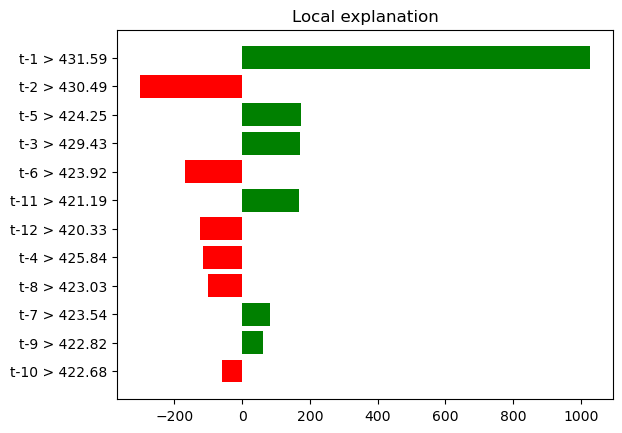

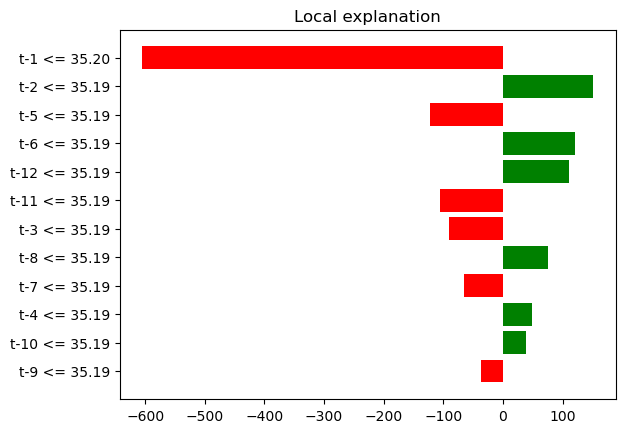

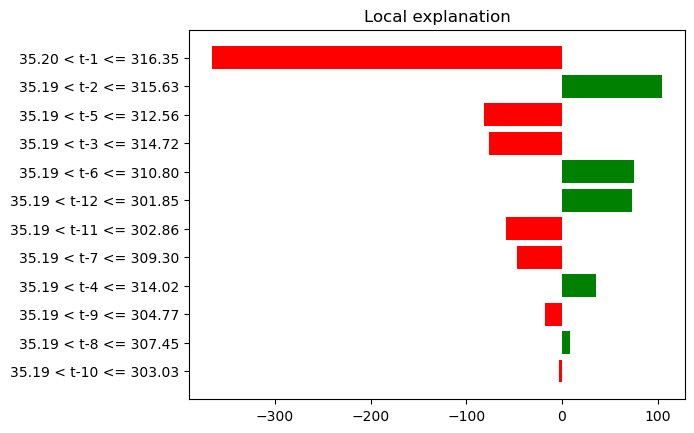

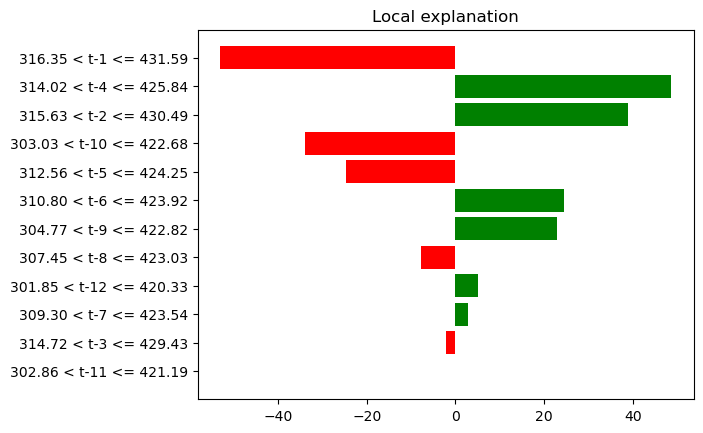

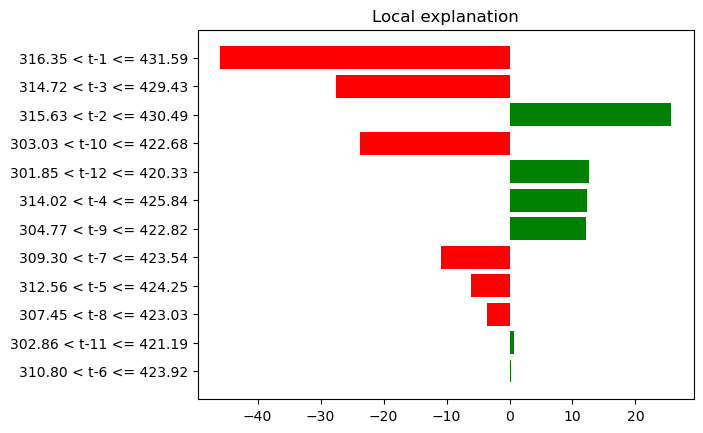

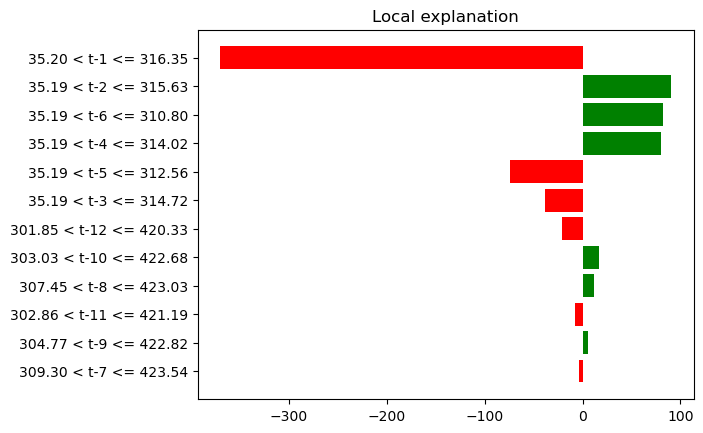

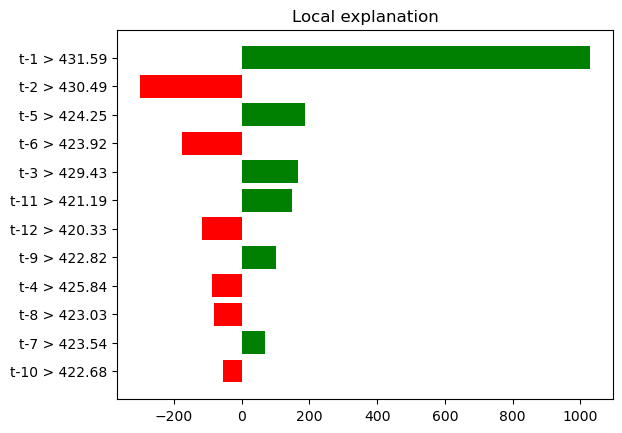

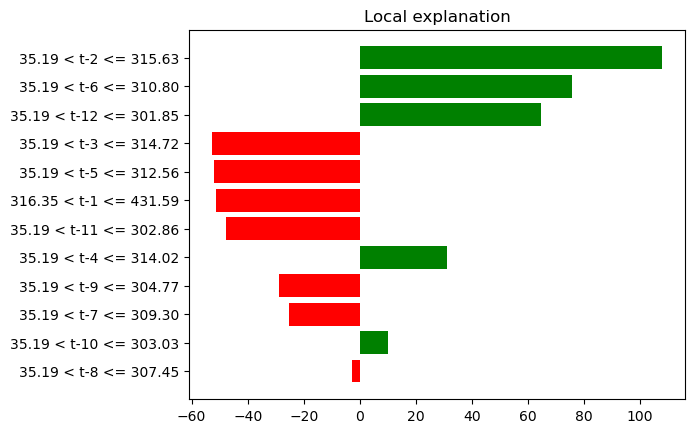

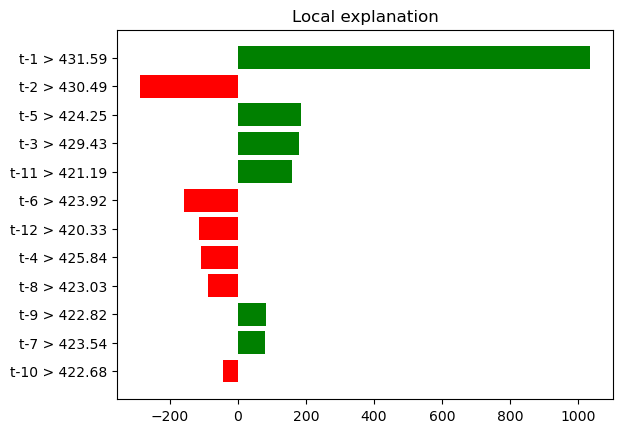

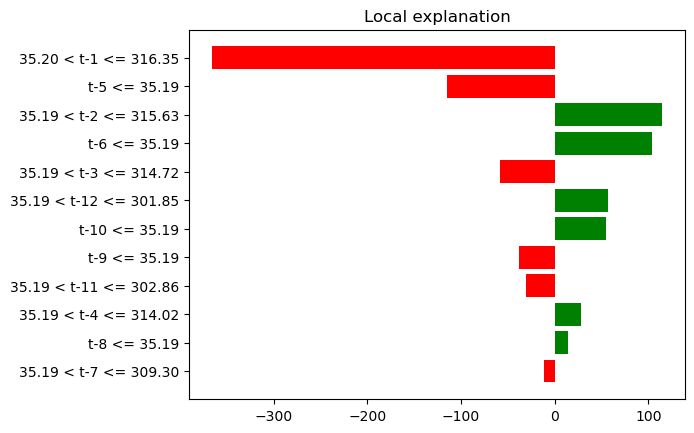

In [63]:
fig_list = [exp.as_pyplot_figure() for exp in sp_obj.sp_explanations]
fig_list


In [ ]:
import skater
from skater import Interpretation

# An Interpretation consumes a dataset, and optionally some meta data like feature names and row ids
interpreter = Interpretation(X, feature_names=X.columns)
interpreter

from skater.model import InMemoryModel
model = InMemoryModel(new_model.predict, examples = X[:10])
model
interpreter.feature_importance.feature_importance(model)
model.model_report(examples=X)
interpreter.load_data(X, feature_names=X.columns)

print("2-way partial dependence plots")
# Features can passed as a tuple for 2-way partial plot
pdp_features = [('t-2', 't-7')]
interpreter.partial_dependence.plot_partial_dependence(
    pdp_features, model, grid_resolution=10
)

ModuleNotFoundError: No module named 'skater'